# Data set gathering

### -----------------------

### This notebook is version 3 of the previous. 
Here were are using loc (new device), loc_old_colored (old device but with names over the channels), checkyour_skin folders with images.

These folders have labels in following excel files.
Checkyourskin - gathered images metadata.csv with ID's, then using these ID's this dataset is merged with labels using 'Ilze_Whatsup_df_checkyrskin_2020_07_28.xlsx' excel.

'LOC_ERAF2017_sakartots.xlsx' is used as labels for LOC datasets (old device (loc_old_colored) and new device (loc))




-----------------------

This notebook aims at preparing checkyourskin and LOC datasets.

The problems are:

For LOC - we don't have info about channels in early images. Only starting from around 2018 images have R / IR /G / UV in their names - which allows to determine their channels.

For Checkyourskin - there are no diagnoze - but there is a file from Dmitry Bliznyuk, with (unfortunately) non-aligned diagnozes (there are no strikt matching :()

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import pandas as pd
import ntpath
import struct
from PIL import Image
import numpy as np
import scipy
import scipy.misc
import scipy.cluster
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from os import listdir
from os.path import isfile, join
from IPython.display import HTML
import io
import base64
import re
import json
from imutils import paths
import argparse
import cv2
from tqdm import tqdm_notebook
from pathlib import Path

%matplotlib inline

In [ ]:
!pip install pystackreg

In [ ]:
os.getcwd()

In [12]:
raw_data_folder_name = '_melanoma'

data_folder = os.path.abspath(os.path.join('../../data/raw', raw_data_folder_name))
data_folder

'/mnt/data/raw/_melanoma'

In [13]:
melanoma_folder = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'data', 'raw', '_melanoma'))

## Let's see excel files 

### HungaryResults.xlsx

In [14]:
hungary_results_xlsx_path =  os.path.join(melanoma_folder, 'HungaryResults.xlsx')
hungary_results = pd.read_excel(hungary_results_xlsx_path, header=1)
hungary_results.head(5)

,Birth,Date of imaging,Clinical diagnosis and sites,Patient ID,Latvian ID number,Histology results,Clark,Breslow
0,1940-06-03 00:00:00,2019-01-21,SK,53.0,108541-00002,Keratosis seborrhoica,NaN,NaN
1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,1940-06-03 00:00:00,2019-01-21,pigmentad BCC/ SK,NaN,NaN,pigmentated BCC,NaN,NaN
3,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,1940-06-03 00:00:00,2019-01-21,BCC,NaN,NaN,Ulcerated nodular BCC \n,NaN,NaN


### LOC_ERAF2017_sakartots.xlsx

In [15]:
loc_eraf2017_xlsx_path =  os.path.join(melanoma_folder, 'LOC_ERAF2017_sakartots.xlsx')
loc_eraf2017 = pd.read_excel(loc_eraf2017_xlsx_path, header=0)
loc_eraf2017.head(5)

,Pacienta nr,Veidojuma Nr,Ārsta diagnoze,Kods,Statuss,"Dzimums (s- sieviete, v- vīrietis)",Dzimšanas gads,"Vecums mērīšanas brīdī, gadi",Lokalizācija,Piezīmes,...,Unnamed: 19,Unnamed: 20,Fototips,"Veidojuma izmērs: GarumsxPlatumsxAugstums, mm",Unnamed: 23,Izmeklējuma veids (d-dermaskopija; s- siaskopija),Apzīmējumi:,updated info,pārbaudīt analīzes,C43
0,1,2,"C44, bazalioma",C44,NaN,NaN,NaN,NaN,kreisais vaigs,apstiprināta bazalioma,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,3,"C44, bazalioma",C44,NaN,NaN,NaN,NaN,Piere,apstiprināta bazalioma,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,4,"C44, bazalioma",C44,NaN,NaN,NaN,NaN,Virslūpa,apstiprināta bazalioma,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,5,"L82, Seborejas keratoze",L82,NaN,NaN,NaN,NaN,Pie auss labajā pusē,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,"Rb, Rēta pēc bazalioma operācijas",Rb,NaN,s,1946,71,Pie auss kreisajā pusē,Uzlabotais prototips no INBIT projekta (operāc...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### LOC_class_2020_04_15b_DB_OK.xlsx --> this is replaced by Ilze_Whatsup_df_checkyrskin_2020_07_28.xlsx
File name is a bit misleading - these are diagnosis codes for the patients from Hungary

In [16]:
df_checkyrskin_2020_07_28_xlsx_path =  os.path.join(melanoma_folder, 'Ilze_Whatsup_df_checkyrskin_2020_07_28.xlsx')
loc_df_checkyrskin_2020_07_28 = pd.read_excel(df_checkyrskin_2020_07_28_xlsx_path, header=0)
loc_df_checkyrskin_2020_07_28.head(15)

,patient_id,measurementId,measurementSetId,measurementComment,measurementDateCreated,measurementDateFinished,receivedImagesCount,deviceId,deviceName,images_paths_list,...,is_uv_images,analyzeId,numberInSequence,analyzeDateCreated,analyzePatientId,analyzeScannedBodyPartId,analyzeDoctorComment,analyzeDiagnosisComment,LesionCode,Paskaidrojums
0,1685,1685,2049752a10138492ccf5e46dbea078ff,NaN,2019-03-29 12:55:16,2019-03-29 10:55:16,20,4,LOC,['/mnt/data/raw/_melanoma/Checkyourskin/1685/i...,...,True,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,3753,3753,593e38ee6500a5f8ad36390293e94351,NaN,2019-12-06 10:15:07,2019-12-06 08:15:07,4,4,LOC,['/mnt/data/raw/_melanoma/Checkyourskin/3753/i...,...,True,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,1367,1367,06634b2a1ff268294a25f1d5e3408746,NaN,2019-03-05 13:10:10,2019-03-05 11:10:10,10,2,Hungary,['/mnt/data/raw/_melanoma/Checkyourskin/1367/i...,...,True,522.0,1.0,2019-03-05 13:16:02,170.0,16.0,"solar keratosis, right side of the forehead",NaN,L57,jeb aktīniskā keratoze
3,309,309,30f589534eed314b2bdbcd41925ab015,NaN,2018-12-12 18:42:29,2018-12-12 16:42:29,3,2,Hungary,['/mnt/data/raw/_melanoma/Checkyourskin/309/in...,...,True,149.0,9.0,2019-01-22 09:53:25,59.0,5.0,test pictures from Latvia,NaN,NaN,testa bildes
4,2162,2162,aace78ffb3981205230d53632804c270,NaN,2019-05-17 20:18:47,2019-05-17 17:18:47,3,4,LOC,['/mnt/data/raw/_melanoma/Checkyourskin/2162/i...,...,True,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
5,2858,2858,eb323d8e0ed8ecc1a29df654b45aa964,NaN,2019-09-06 10:32:37,2019-09-06 07:32:37,4,4,LOC,['/mnt/data/raw/_melanoma/Checkyourskin/2858/i...,...,True,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
6,1713,1713,b20d87df92adf96f2503bb3d57b9ce18,NaN,2019-04-01 11:48:31,2019-04-01 08:48:31,10,2,Hungary,['/mnt/data/raw/_melanoma/Checkyourskin/1713/i...,...,True,741.0,1.0,2019-04-01 11:50:46,211.0,26.0,dysplastic naevus on the left shoulder,NaN,D48,NaN
7,2543,2543,03a276820640fb82b99b9f173a7e3381,NaN,2019-07-10 09:59:48,2019-07-10 06:59:48,3,4,LOC,['/mnt/data/raw/_melanoma/Checkyourskin/2543/i...,...,True,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
8,3838,3838,32b2fc50d85338d8c773c01b0f8158a1,NaN,2019-12-09 12:44:18,2019-12-09 10:44:18,20,4,LOC,['/mnt/data/raw/_melanoma/Checkyourskin/3838/i...,...,True,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
9,2604,2604,6c09c9751538deb857f93166166b17af,NaN,2019-07-19 11:50:24,2019-07-19 08:50:24,3,4,LOC,['/mnt/data/raw/_melanoma/Checkyourskin/2604/i...,...,True,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
loc_df_checkyrskin_2020_07_28[loc_df_checkyrskin_2020_07_28['LesionCode']=='C43'].shape

(64, 21)

### extra_melanoma.xlsx
<!-- Hand picked melanomas (c43 + c44) by Yuriy Chizhov -->

In [18]:
# loc_extra_melanomas_xlsx_path =  os.path.join(melanoma_folder, 'extra_melanoma.xlsx')
# loc_extra_melanomas = pd.read_excel(loc_extra_melanomas_xlsx_path, header=0)
# # loc_extra_melanomas.head(5)

## LOC images
Let's gather all R/G/IR/UV images (paths) from within LOC along with their diagnoses. 

In [19]:
melanoma_folder = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'data', 'raw', '_melanoma'))

merijumi_loc_folder =  os.path.join(melanoma_folder, 'Merijumi LOC')
print(merijumi_loc_folder)

/mnt/data/raw/_melanoma/Merijumi LOC


- First level can be skipped
- Second level contains patient ID and exact date with per person data in subfolders
1) We are looking for subfolders with '.tar' in their names. (Starting with 2019-04, because these folders have R/IR/G/UV in files names and we can use them)

In [20]:
def load_metadata_csv(tar_folder_path: str):
    csv_path = os.path.join(tar_folder_path, 'metadata', 'metadata.csv')
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
#         return df.to_json()
        if len(df.to_dict('records')) > 1:
            print('Multi-row metadata.csv encountered:', csv_path)
            print(df.head())
            
        return df.to_dict('records')[0]
    else:
#         print('File not exists! ', csv_path)
        return {}

def collect_images(tar_folder_path: str):
    images_paths_list = []
    in_folder_path = os.path.join(tar_folder_path, 'in')
    
    uv_images = False
    if os.path.exists(in_folder_path):
        for in_folder_file in os.listdir(in_folder_path):
            img_file = os.path.join(in_folder_path, in_folder_file)
            if os.path.isfile(img_file):
                if '.png' in in_folder_file or '.jpg' in in_folder_file or '.jpeg' in in_folder_file or '.tiff' in in_folder_file:
                    
                    images_paths_list.append(img_file)
                    if uv_images == False and in_folder_file.startswith('UV'):
                        uv_images = True
                        
#                     print('Image found:', in_folder_file)
                else:
#                     print('Skipping file: ', in_folder_file)
                    pass
            else:
#                 print('Found folder in "in" subfolder: ', in_folder_path, in_folder_file)
                pass
    else:
#         print('"in" Folder not exists!', in_folder_path)
        pass
        
    return images_paths_list, uv_images
                    
            
def process_tar_folder(tar_folder_path: str, date: str, patient_id: str):
#     print('process_tar_folder', tar_folder_path)
    
    if 'kluda' in tar_folder_path or 'error' in tar_folder_path or 'analizei' in tar_folder_path:
        return []
    
    # We assume that above level contains "lesion_id"
    parent_folder_path = Path(tar_folder_path).parent
#     print('parent_folder_path', parent_folder_path)
    lesion_id = parent_folder_path.name
    
    metadata_json = load_metadata_csv(tar_folder_path)
    images_paths_list, is_uv_images = collect_images(tar_folder_path)
    metadata_json['images_paths_list'] = images_paths_list
    metadata_json['date'] = date
    metadata_json['patient_id'] = patient_id
    metadata_json['lesion_id'] = lesion_id
    metadata_json['is_uv_images'] = is_uv_images
    return [metadata_json]
    

def process_subfolders(root_folder_path: str, date: str, patient_id: str):
    if os.path.isdir(root_folder_path):
        if 'tar' in root_folder_path:
            return process_tar_folder(root_folder_path, date, patient_id)
        else:
            results_list = []
            for subfolder in os.listdir(root_folder_path):
                subfolder_path = os.path.join(root_folder_path, subfolder)
                subresults_list = process_subfolders(subfolder_path, date, patient_id)
                if len(subresults_list) > 0:
                    results_list.extend(subresults_list)
            return results_list
    else:
        return []
    
def process_loc_root_folder(_folder: str):
    full_rows_list = []
    for level1_folder in os.listdir(_folder):
        level1_subfolder = os.path.join(_folder, level1_folder)
        level1_date = level1_folder
        if os.path.isdir(level1_subfolder):
            for date_patient_id_folder in os.listdir(level1_subfolder):
                date_patient_id_folder_path = os.path.join(level1_subfolder, date_patient_id_folder)
                if os.path.isdir(date_patient_id_folder_path) \
                   and 'VISION' not in date_patient_id_folder \
                   and 'bonuss' not in date_patient_id_folder:
                    if len(date_patient_id_folder) >= 10: 
                        date = date_patient_id_folder[0:10]
                        patient_id = date_patient_id_folder[11:]
                    else:
                        date = level1_date
                        patient_id = date_patient_id_folder

                    print('folder:', date_patient_id_folder, ': date-', date, ': patient_id-', patient_id, '----')

                    rows_list = process_subfolders(date_patient_id_folder_path, date, patient_id) 
                    full_rows_list.extend(rows_list)
    return full_rows_list

In [21]:
full_rows_list = process_loc_root_folder(merijumi_loc_folder)

folder: 2018_02_09 : date- 2018_02_09 : patient_id-  ----
folder: 2018_02_09_88 : date- 2018_02_09 : patient_id- 88 ----
folder: 2018_02_12_90 : date- 2018_02_12 : patient_id- 90 ----
folder: 2018_02_07_85 : date- 2018_02_07 : patient_id- 85 ----
folder: 2018_02_07_87 : date- 2018_02_07 : patient_id- 87 ----
folder: 84 : date- 2018_02 : patient_id- 84 ----
folder: 2018_02_12_89 : date- 2018_02_12 : patient_id- 89 ----
folder: 83 : date- 2018_02 : patient_id- 83 ----
folder: 2018_02_07_86 : date- 2018_02_07 : patient_id- 86 ----
folder: 82 : date- 2018_02 : patient_id- 82 ----
folder: 2018-07-02_145 : date- 2018-07-02 : patient_id- 145 ----
folder: 2018-07-27_150 : date- 2018-07-27 : patient_id- 150 ----
folder: 2018-07-30_153 : date- 2018-07-30 : patient_id- 153 ----
folder: 2018-07-02_143 : date- 2018-07-02 : patient_id- 143 ----
folder: 2018-07-04_147 : date- 2018-07-04 : patient_id- 147 ----
folder: 2018-07-02_144 : date- 2018-07-02 : patient_id- 144 ----
folder: 2018-07-30_154 : da

folder: 2019-11-29_310 : date- 2019-11-29 : patient_id- 310 ----
folder: 2019-11-08_306 : date- 2019-11-08 : patient_id- 306 ----
folder: 2019-11-25_308 : date- 2019-11-25 : patient_id- 308 ----
folder: 2019-11-29_311 : date- 2019-11-29 : patient_id- 311 ----
folder: 2019-11-29_309 : date- 2019-11-29 : patient_id- 309 ----
folder: 2019-11-11_132B : date- 2019-11-11 : patient_id- 132B ----
folder: 2019-11-25_307 : date- 2019-11-25 : patient_id- 307 ----
folder: 2018_04_09_106 : date- 2018_04_09 : patient_id- 106 ----
folder: 2018_04_06_103 : date- 2018_04_06 : patient_id- 103 ----
folder: 2018-04-18-107 : date- 2018-04-18 : patient_id- 107 ----
folder: 2018-04-25_112 : date- 2018-04-25 : patient_id- 112 ----
folder: 2018-04-23_109 : date- 2018-04-23 : patient_id- 109 ----
folder: 2018-04-25_113 : date- 2018-04-25 : patient_id- 113 ----
folder: 2018-04-23_108 : date- 2018-04-23 : patient_id- 108 ----
folder: 2018-04-18_47B : date- 2018-04-18 : patient_id- 47B ----
folder: 2018_04_09_105 

folder: 2019-05-27_247 : date- 2019-05-27 : patient_id- 247 ----
folder: 2019-05-24_244 : date- 2019-05-24 : patient_id- 244 ----
folder: 2019-05-10_239 : date- 2019-05-10 : patient_id- 239 ----
folder: 2019-05-20_242 : date- 2019-05-20 : patient_id- 242 ----
folder: 2019-05-27_248 : date- 2019-05-27 : patient_id- 248 ----
folder: 2019-05-24_246 : date- 2019-05-24 : patient_id- 246 ----
folder: 2019-05-24_245 : date- 2019-05-24 : patient_id- 245 ----
folder: 2019-05-13_241 : date- 2019-05-13 : patient_id- 241 ----
folder: 2019-05-10_237 : date- 2019-05-10 : patient_id- 237 ----
folder: 2019-05-22_243 : date- 2019-05-22 : patient_id- 243 ----
folder: 2019-08-09_277 : date- 2019-08-09 : patient_id- 277 ----
folder: 2019-08-14_94B : date- 2019-08-14 : patient_id- 94B ----
folder: 2019-08-19_110B : date- 2019-08-19 : patient_id- 110B ----
folder: 2019-08-14_279 : date- 2019-08-14 : patient_id- 279 ----
folder: 2019-08-21_281 : date- 2019-08-21 : patient_id- 281 ----
folder: 2019-08-05_206B

In [22]:
len(full_rows_list)

1089

In [23]:
df_loc = pd.DataFrame(full_rows_list)

In [24]:
df_loc.head(4)

,measurementId,measurementSetId,measurementComment,measurementDateCreated,measurementDateFinished,receivedImagesCount,deviceId,deviceName,images_paths_list,date,patient_id,lesion_id,is_uv_images
0,2643.0,49e43a7cf5fcb6a1244253894db4adcd,NaN,2019-07-22 11:16:21,2019-07-22 08:16:21,4.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,272,5,False
1,2642.0,90c6d827c611acfc47aa828b301ad9da,NaN,2019-07-22 11:16:19,2019-07-22 08:16:19,20.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,272,5,True
2,2640.0,f22f8bbe78a2c8e8fe4562237890e1dd,NaN,2019-07-22 11:15:17,2019-07-22 08:15:17,4.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,272,4,False
3,2641.0,0673de7e1c166d00b7c45b27ebfda5b2,NaN,2019-07-22 11:15:20,2019-07-22 08:15:20,20.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,272,4,True


#### LOC UV images - selection of most sharp image (with least amount of blur -> largest variance_of_laplacian coeficient)

In [25]:
# BLUR DETECTION - in case one will need to find imagge with lowest blur (highest variance of laplacian)
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [26]:
import ntpath
def get_best_uv_file_path(images_paths_list):
    
    # It was decided to take just first UV image.
    folder_path, _ = ntpath.split(images_paths_list[0])
    
    file_names_list = [ntpath.basename(i) for i in images_paths_list]
    file_names_list.sort()
    first_file_name = file_names_list[0]
    
    return cv.imread(os.path(folder_path, first_file_name)), 1.0
    
#     max_var_of_laplacian = -1
#     sharpest_image = None
#     for img_path in images_paths_list:
#         try:
#             cv2_img = cv2.imread(img_path)
#             var_of_laplacian = variance_of_laplacian(cv2_img)
#             if var_of_laplacian > max_var_of_laplacian:
#                 sharpest_image = img_path
#         except Exception as e:
#             print('Error occured! img_path=', img_path, 'Exception:', e)
            
#     return sharpest_image, max_var_of_laplacian

def find_best_uv_images_paths(df_loc):
    df_loc['best_uv_file_path'] = ""
    
    for i in tqdm_notebook(df_loc.index):
        if df_loc.at[i, 'is_uv_images']:
            best_uv_file_path, _ = get_best_uv_file_path(df_loc.at[i, 'images_paths_list'])
            df_loc.at[i, 'best_uv_file_path'] = best_uv_file_path
        else:
            df_loc.at[i, 'best_uv_file_path'] = None
            
# find_best_uv_images_paths(df_loc)

In [27]:
# df_loc.head(10)

#### Merge df_loc with LOC_ERAF2017_sakartots.xlsx - diagnoses for our images.

In [28]:
loc_eraf2017.rename(columns={'Pacienta nr': 'patient_id', 'Veidojuma Nr': 'lesion_id'}, inplace=True)

In [29]:
loc_eraf2017['patient_id'] = pd.to_numeric(loc_eraf2017['patient_id'], errors='coerce', downcast='signed')
loc_eraf2017['lesion_id'] = pd.to_numeric(loc_eraf2017['lesion_id'], errors='coerce', downcast='signed')

In [30]:
df_loc['patient_id'] = pd.to_numeric(df_loc['patient_id'], errors='coerce', downcast='signed')
df_loc['lesion_id'] = pd.to_numeric(df_loc['lesion_id'], errors='coerce', downcast='signed')

In [31]:
df_loc_merged = pd.merge(df_loc, loc_eraf2017, how='inner', on=['patient_id', 'lesion_id'])

### Find missing C43 - where did they go?

In [32]:
# df = df1.merge(df2, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
df_loc_merged_outleft = pd.merge(df_loc, loc_eraf2017, how='outer', on=['patient_id', 'lesion_id'], indicator=True).loc[lambda x : x['_merge']=='left_only']
df_loc_merged_outright = pd.merge(df_loc, loc_eraf2017, how='outer', on=['patient_id', 'lesion_id'], indicator=True).loc[lambda x : x['_merge']=='right_only']

In [33]:
df_loc_merged_outright.head()

,measurementId,measurementSetId,measurementComment,measurementDateCreated,measurementDateFinished,receivedImagesCount,deviceId,deviceName,images_paths_list,date,...,Unnamed: 20,Fototips,"Veidojuma izmērs: GarumsxPlatumsxAugstums, mm",Unnamed: 23,Izmeklējuma veids (d-dermaskopija; s- siaskopija),Apzīmējumi:,updated info,pārbaudīt analīzes,C43,_merge
1219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
1220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
1221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
1222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
1223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only


In [34]:
df_loc_merged_outright[df_loc_merged_outright['Kods']=='C43']['Kods']

1337    C43
1407    C43
1545    C43
1565    C43
1641    C43
1642    C43
1934    C43
2012    C43
2013    C43
2176    C43
2231    C43
2234    C43
2252    C43
2280    C43
2507    C43
2516    C43
2529    C43
2532    C43
2805    C43
2806    C43
Name: Kods, dtype: object

In [35]:
loc_eraf2017.shape

(2028, 29)

In [36]:
df_loc_merged_outright.shape

(1607, 41)

In [37]:
loc_eraf2017[loc_eraf2017['Kods']=='C43'].shape

(21, 29)

In [38]:
df_loc_merged_outleft[df_loc_merged_outleft['Kods'] == 'C43'].head()

,measurementId,measurementSetId,measurementComment,measurementDateCreated,measurementDateFinished,receivedImagesCount,deviceId,deviceName,images_paths_list,date,...,Unnamed: 20,Fototips,"Veidojuma izmērs: GarumsxPlatumsxAugstums, mm",Unnamed: 23,Izmeklējuma veids (d-dermaskopija; s- siaskopija),Apzīmējumi:,updated info,pārbaudīt analīzes,C43,_merge


In [39]:
df_loc_merged_outright[df_loc_merged_outright['Kods'] == 'C43'].index

Int64Index([1337, 1407, 1545, 1565, 1641, 1642, 1934, 2012, 2013, 2176, 2231,
            2234, 2252, 2280, 2507, 2516, 2529, 2532, 2805, 2806],
           dtype='int64')

In [40]:
# let's get indexes of C43 comming from right part of merge - from 'loc_eraf2017'
df_loc_c43_indexes_right = df_loc_merged_outright[df_loc_merged_outright['Kods'] == 'C43'].index

In [41]:
type(df_loc_c43_indexes_right)

pandas.core.indexes.numeric.Int64Index

In [42]:
list(df_loc.columns)

['measurementId',
 'measurementSetId',
 'measurementComment',
 'measurementDateCreated',
 'measurementDateFinished',
 'receivedImagesCount',
 'deviceId',
 'deviceName',
 'images_paths_list',
 'date',
 'patient_id',
 'lesion_id',
 'is_uv_images']

In [43]:
# list(loc_eraf2017.columns)

In [44]:
# df_loc[df_loc['Kods']=='C43'].index()

In [45]:
# df_loc, loc_eraf2017

In [46]:
# # let's extract records from loc_eraf2017 corresponding to mismatched (emtpy) indexes
# loc_eraf2017.iloc[[1337, 1407, 1545, 1565, 1641, 1642, 1934, 2012, 2013, 2176, 2231, 2234, 2252, 2280, 2507, 2516, 2529, 2532, 2805, 2806]]

In [47]:
df_loc_merged_outright[df_loc_merged_outright['Kods'] == 'C43']

,measurementId,measurementSetId,measurementComment,measurementDateCreated,measurementDateFinished,receivedImagesCount,deviceId,deviceName,images_paths_list,date,...,Unnamed: 20,Fototips,"Veidojuma izmērs: GarumsxPlatumsxAugstums, mm",Unnamed: 23,Izmeklējuma veids (d-dermaskopija; s- siaskopija),Apzīmējumi:,updated info,pārbaudīt analīzes,C43,_merge
1337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
1407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
1545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
1565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
1641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
1642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
1934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
2176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only


In [48]:
df_loc_merged.tail()

,measurementId,measurementSetId,measurementComment,measurementDateCreated,measurementDateFinished,receivedImagesCount,deviceId,deviceName,images_paths_list,date,...,Unnamed: 19,Unnamed: 20,Fototips,"Veidojuma izmērs: GarumsxPlatumsxAugstums, mm",Unnamed: 23,Izmeklējuma veids (d-dermaskopija; s- siaskopija),Apzīmējumi:,updated info,pārbaudīt analīzes,C43
1110,3232.0,7579eb676b26f2481399860c6b1b4359,NaN,2019-10-25 11:00:13,2019-10-25 08:00:13,4.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_10/...,2019-10-25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1111,3231.0,36c5c619d6a2475a7947453ab5aba70e,NaN,2019-10-25 10:59:31,2019-10-25 07:59:31,20.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_10/...,2019-10-25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1112,3230.0,753edc70b8b127137d631041ec33286d,NaN,2019-10-25 10:59:02,2019-10-25 07:59:02,4.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_10/...,2019-10-25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1113,3121.0,97a69d9d87c561c2893eb5a332deb054,NaN,2019-10-14 10:40:16,2019-10-14 07:40:16,20.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_10/...,2019-10-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1114,3120.0,a62909cd1a5f85877c2619eb76a5c7e4,NaN,2019-10-14 10:39:54,2019-10-14 07:39:54,4.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_10/...,2019-10-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# df_loc_merged.loc[df_loc_merged['patient_id'] == 272][['date', 'patient_id', 'lesion_id', 'is_uv_images', 'best_uv_file_path', 'Ārsta diagnoze', 'Kods']]

In [50]:
# print(list(df_loc_merged.columns))

In [51]:
df_loc_merged.shape

(1115, 40)

In [52]:
df_loc_merged[['measurementId',
 'measurementSetId',
 'measurementComment',
 'measurementDateCreated',
 'measurementDateFinished',
 'receivedImagesCount',
 'deviceId',
 'deviceName',
 'images_paths_list',
 'date',
 'patient_id',
 'lesion_id',
 'is_uv_images',
 'Ārsta diagnoze',
 'Kods']].head(50)

,measurementId,measurementSetId,measurementComment,measurementDateCreated,measurementDateFinished,receivedImagesCount,deviceId,deviceName,images_paths_list,date,patient_id,lesion_id,is_uv_images,Ārsta diagnoze,Kods
0,2643.0,49e43a7cf5fcb6a1244253894db4adcd,NaN,2019-07-22 11:16:21,2019-07-22 08:16:21,4.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,272.0,5.0,False,D48,D48
1,2642.0,90c6d827c611acfc47aa828b301ad9da,NaN,2019-07-22 11:16:19,2019-07-22 08:16:19,20.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,272.0,5.0,True,D48,D48
2,2640.0,f22f8bbe78a2c8e8fe4562237890e1dd,NaN,2019-07-22 11:15:17,2019-07-22 08:15:17,4.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,272.0,4.0,False,BCC pēc imikvimod terapijas,C44imi
3,2641.0,0673de7e1c166d00b7c45b27ebfda5b2,NaN,2019-07-22 11:15:20,2019-07-22 08:15:20,20.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,272.0,4.0,True,BCC pēc imikvimod terapijas,C44imi
4,2644.0,a25e8d6028098a91fcc4021fe013d2a4,NaN,2019-07-22 11:17:07,2019-07-22 08:17:07,4.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,272.0,6.0,False,D48,D48
5,2645.0,14e2128a8e5b1ece23ffb7fa717ef6d1,NaN,2019-07-22 11:17:11,2019-07-22 08:17:11,20.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,272.0,6.0,True,D48,D48
6,2646.0,5ad9b8be49e6ccfc88ca6992e4231c03,NaN,2019-07-22 11:18:17,2019-07-22 08:18:17,4.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,272.0,7.0,False,BCC pēc imikvimod terapijas,C44imi
7,2647.0,58a0dcd251e806755a8ece46fbc8773d,NaN,2019-07-22 11:18:17,2019-07-22 08:18:17,20.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,272.0,7.0,True,BCC pēc imikvimod terapijas,C44imi
8,2639.0,acf2324b0fdeb2a46ed09d3e5b7f6e15,NaN,2019-07-22 11:14:37,2019-07-22 08:14:37,20.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,272.0,3.0,True,BCC pēc imikvimod terapijas,C44imi
9,2638.0,9f1a76c06f2bd155eda49848d0d8bdc2,NaN,2019-07-22 11:14:34,2019-07-22 08:14:34,4.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,272.0,3.0,False,BCC pēc imikvimod terapijas,C44imi


In [53]:
# pd.set_option('display.max_columns', None)  
# pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', -1)
df_loc_merged.head(50)

,measurementId,measurementSetId,measurementComment,measurementDateCreated,measurementDateFinished,receivedImagesCount,deviceId,deviceName,images_paths_list,date,...,Unnamed: 19,Unnamed: 20,Fototips,"Veidojuma izmērs: GarumsxPlatumsxAugstums, mm",Unnamed: 23,Izmeklējuma veids (d-dermaskopija; s- siaskopija),Apzīmējumi:,updated info,pārbaudīt analīzes,C43
0,2643.0,49e43a7cf5fcb6a1244253894db4adcd,NaN,2019-07-22 11:16:21,2019-07-22 08:16:21,4.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2642.0,90c6d827c611acfc47aa828b301ad9da,NaN,2019-07-22 11:16:19,2019-07-22 08:16:19,20.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2640.0,f22f8bbe78a2c8e8fe4562237890e1dd,NaN,2019-07-22 11:15:17,2019-07-22 08:15:17,4.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2641.0,0673de7e1c166d00b7c45b27ebfda5b2,NaN,2019-07-22 11:15:20,2019-07-22 08:15:20,20.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2644.0,a25e8d6028098a91fcc4021fe013d2a4,NaN,2019-07-22 11:17:07,2019-07-22 08:17:07,4.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2645.0,14e2128a8e5b1ece23ffb7fa717ef6d1,NaN,2019-07-22 11:17:11,2019-07-22 08:17:11,20.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2646.0,5ad9b8be49e6ccfc88ca6992e4231c03,NaN,2019-07-22 11:18:17,2019-07-22 08:18:17,4.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2647.0,58a0dcd251e806755a8ece46fbc8773d,NaN,2019-07-22 11:18:17,2019-07-22 08:18:17,20.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2639.0,acf2324b0fdeb2a46ed09d3e5b7f6e15,NaN,2019-07-22 11:14:37,2019-07-22 08:14:37,20.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2638.0,9f1a76c06f2bd155eda49848d0d8bdc2,NaN,2019-07-22 11:14:34,2019-07-22 08:14:34,4.0,4.0,LOC,[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/...,2019-07-22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


These 1115 images - should be divided by 2 to get real number of cases (because we have two records R/IR/G + UV for each case)

In addition in the old LOC pre-"2019-04" data - there are some melanomas. We would like to manually cherrypick them and include in our dataset.

## Checkyourskin images

In [54]:
melanoma_folder = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'data', 'raw', '_melanoma'))

checkyourskin_folder =  os.path.join(melanoma_folder, 'Checkyourskin')
print(checkyourskin_folder)

/mnt/data/raw/_melanoma/Checkyourskin


In [55]:
def collect_images_cys(tar_folder_path: str):
    images_paths_list = []
    in_folder_path = os.path.join(tar_folder_path, 'in')
    
    uv_images = False
    if os.path.exists(in_folder_path):
        for in_folder_file in os.listdir(in_folder_path):
            img_file = os.path.join(in_folder_path, in_folder_file)
            if os.path.isfile(img_file):
                if '.png' in in_folder_file or '.jpg' in in_folder_file or '.jpeg' in in_folder_file or '.tiff' in in_folder_file:
                    
                    images_paths_list.append(img_file)
                    if uv_images == False and (not in_folder_file.startswith('R') or not in_folder_file.startswith('IR') or not in_folder_file.startswith('G')):
                        uv_images = True
                        
#                     print('Image found:', in_folder_file)
                else:
#                     print('Skipping file: ', in_folder_file)
                    pass
            else:
#                 print('Found folder in "in" subfolder: ', in_folder_path, in_folder_file)
                pass
    else:
#         print('"in" Folder not exists!', in_folder_path)
        pass
        
    return images_paths_list, uv_images

def process_tar_folder_cys(tar_folder_path: str, patient_id: str):
#     print('process_tar_folder_cys', tar_folder_path)
    
    # We assume that above level contains "lesion_id"
    parent_folder_path = Path(tar_folder_path).parent
#     print('parent_folder_path', parent_folder_path)
    lesion_id = parent_folder_path.name
    
    metadata_json = load_metadata_csv(tar_folder_path)
    images_paths_list, is_uv_images = collect_images_cys(tar_folder_path)
    metadata_json['images_paths_list'] = images_paths_list
    metadata_json['patient_id'] = patient_id
    metadata_json['lesion_id'] = lesion_id
    metadata_json['is_uv_images'] = is_uv_images
    return [metadata_json]

def process_cys_root_folder(_folder: str):
    full_rows_list = []
    for patient_id_folder in tqdm_notebook(os.listdir(_folder)):
#         print(patient_id_folder)
        patient_id_folder_path = os.path.join(_folder, patient_id_folder)
        if os.path.isdir(patient_id_folder_path):
            patient_id = patient_id_folder
#             print('folder:', patient_id_folder_path, ': patient_id-', patient_id, '----')
            rows_list = process_tar_folder_cys(patient_id_folder_path, patient_id)
            full_rows_list.extend(rows_list)
    return full_rows_list

In [56]:
checkyourskin_folder

'/mnt/data/raw/_melanoma/Checkyourskin'

In [57]:
full_rows_list_cys = process_cys_root_folder(checkyourskin_folder)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [58]:
# full_rows_list_cys[0:10]

In [59]:
df_cys = pd.DataFrame(full_rows_list_cys)

In [60]:
df_cys.head(5)

,measurementId,measurementSetId,measurementComment,measurementDateCreated,measurementDateFinished,receivedImagesCount,deviceId,deviceName,images_paths_list,patient_id,lesion_id,is_uv_images,analyzeId,numberInSequence,analyzeDateCreated,analyzePatientId,analyzeScannedBodyPartId,analyzeDoctorComment,analyzeDiagnosisComment
0,1685,2049752a10138492ccf5e46dbea078ff,NaN,2019-03-29 12:55:16,2019-03-29 10:55:16,20,4,LOC,[/mnt/data/raw/_melanoma/Checkyourskin/1685/in...,1685,Checkyourskin,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3753,593e38ee6500a5f8ad36390293e94351,NaN,2019-12-06 10:15:07,2019-12-06 08:15:07,4,4,LOC,[/mnt/data/raw/_melanoma/Checkyourskin/3753/in...,3753,Checkyourskin,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1367,06634b2a1ff268294a25f1d5e3408746,NaN,2019-03-05 13:10:10,2019-03-05 11:10:10,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1367/in...,1367,Checkyourskin,True,522.0,1.0,2019-03-05 13:16:02,170.0,16.0,"solar keratosis, right side of the forehead",NaN
3,309,30f589534eed314b2bdbcd41925ab015,NaN,2018-12-12 18:42:29,2018-12-12 16:42:29,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/309/in/...,309,Checkyourskin,True,149.0,9.0,2019-01-22 09:53:25,59.0,5.0,test pictures from Latvia,NaN
4,2162,aace78ffb3981205230d53632804c270,NaN,2019-05-17 20:18:47,2019-05-17 17:18:47,3,4,LOC,[/mnt/data/raw/_melanoma/Checkyourskin/2162/in...,2162,Checkyourskin,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
# Save this dataframe to CSV file
df_cys.to_csv('/mnt/df_checkyrskin.csv', index=False)

In [62]:
# df_cys.loc[df_cys['analyzeDoctorComment']=='pigmented basalioma'].head(50)

In [63]:
loc_df_checkyrskin_2020_07_28.head()

,patient_id,measurementId,measurementSetId,measurementComment,measurementDateCreated,measurementDateFinished,receivedImagesCount,deviceId,deviceName,images_paths_list,...,is_uv_images,analyzeId,numberInSequence,analyzeDateCreated,analyzePatientId,analyzeScannedBodyPartId,analyzeDoctorComment,analyzeDiagnosisComment,LesionCode,Paskaidrojums
0,1685,1685,2049752a10138492ccf5e46dbea078ff,NaN,2019-03-29 12:55:16,2019-03-29 10:55:16,20,4,LOC,['/mnt/data/raw/_melanoma/Checkyourskin/1685/i...,...,True,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,3753,3753,593e38ee6500a5f8ad36390293e94351,NaN,2019-12-06 10:15:07,2019-12-06 08:15:07,4,4,LOC,['/mnt/data/raw/_melanoma/Checkyourskin/3753/i...,...,True,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,1367,1367,06634b2a1ff268294a25f1d5e3408746,NaN,2019-03-05 13:10:10,2019-03-05 11:10:10,10,2,Hungary,['/mnt/data/raw/_melanoma/Checkyourskin/1367/i...,...,True,522.0,1.0,2019-03-05 13:16:02,170.0,16.0,"solar keratosis, right side of the forehead",NaN,L57,jeb aktīniskā keratoze
3,309,309,30f589534eed314b2bdbcd41925ab015,NaN,2018-12-12 18:42:29,2018-12-12 16:42:29,3,2,Hungary,['/mnt/data/raw/_melanoma/Checkyourskin/309/in...,...,True,149.0,9.0,2019-01-22 09:53:25,59.0,5.0,test pictures from Latvia,NaN,NaN,testa bildes
4,2162,2162,aace78ffb3981205230d53632804c270,NaN,2019-05-17 20:18:47,2019-05-17 17:18:47,3,4,LOC,['/mnt/data/raw/_melanoma/Checkyourskin/2162/i...,...,True,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
# let us filter out LOC records
df_cys = df_cys.loc[df_cys['deviceName'] != 'LOC']

In [65]:
df_cys.shape

(971, 19)

In [66]:
def add_diagnose_codes(loc_df_checkyrskin_2020_07_28, df_cys):
    """
    get codes from loc_df_checkyrskin_2020_07_28 and put them into df_cys using comment as a matching thing
    """
    df_with_codes = loc_df_checkyrskin_2020_07_28.copy(deep=True)
    df_with_codes.dropna(subset = ['LesionCode'], inplace=True)
    df_with_codes = df_with_codes[~df_with_codes['LesionCode'].str.contains(',')]
    df_with_codes = df_with_codes[~df_with_codes['LesionCode'].str.contains('\?')]
    df_with_codes = df_with_codes[['analyzeId', 'LesionCode']]
    
    df_cys = df_cys.copy(deep=True)
    df_cys = df_cys.merge(df_with_codes, how='left', left_on='analyzeId', right_on='analyzeId')
    df_cys['code'] = df_cys['LesionCode']
    return df_cys
    
df_cys = add_diagnose_codes(loc_df_checkyrskin_2020_07_28, df_cys)

In [67]:
# loc_df_checkyrskin_2020_07_28[loc_df_checkyrskin_2020_07_28['LesionCode']=='C43']

In [68]:
# drop rows with NaN codes
# df_cys = df_cys.dropna(subset = ['code'])

In [69]:
df_cys.head(15)

,measurementId,measurementSetId,measurementComment,measurementDateCreated,measurementDateFinished,receivedImagesCount,deviceId,deviceName,images_paths_list,patient_id,...,is_uv_images,analyzeId,numberInSequence,analyzeDateCreated,analyzePatientId,analyzeScannedBodyPartId,analyzeDoctorComment,analyzeDiagnosisComment,LesionCode,code
0,1367,06634b2a1ff268294a25f1d5e3408746,NaN,2019-03-05 13:10:10,2019-03-05 11:10:10,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1367/in...,1367,...,True,522.0,1.0,2019-03-05 13:16:02,170.0,16.0,"solar keratosis, right side of the forehead",NaN,L57,L57
1,309,30f589534eed314b2bdbcd41925ab015,NaN,2018-12-12 18:42:29,2018-12-12 16:42:29,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/309/in/...,309,...,True,149.0,9.0,2019-01-22 09:53:25,59.0,5.0,test pictures from Latvia,NaN,NaN,NaN
2,1713,b20d87df92adf96f2503bb3d57b9ce18,NaN,2019-04-01 11:48:31,2019-04-01 08:48:31,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1713/in...,1713,...,True,741.0,1.0,2019-04-01 11:50:46,211.0,26.0,dysplastic naevus on the left shoulder,NaN,D48,D48
3,345,34df6a8d8b378471d7852a7c2b2c0430,NaN,2018-12-17 14:05:25,2018-12-17 12:05:25,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/345/in/...,345,...,True,149.0,32.0,2019-01-22 09:53:25,59.0,5.0,test pictures from Latvia,NaN,NaN,NaN
4,1394,94da4f751a78642a4fa299ecfa3b6bae,NaN,2019-03-07 13:42:29,2019-03-07 11:42:29,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1394/in...,1394,...,True,550.0,1.0,2019-03-07 14:47:34,175.0,27.0,"pxe, axillar, lateral",NaN,PXE,PXE
5,1729,a0bfd1f50d93ca9c75711b1492fd911b,NaN,2019-04-02 10:36:42,2019-04-02 07:36:42,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1729/in...,1729,...,True,759.0,1.0,2019-04-02 10:48:19,214.0,68.0,BCC 9h,NaN,C44,C44
6,1835,1cc0150b7e91da704fd6eb50998a7e4c,NaN,2019-04-08 13:10:10,2019-04-08 10:10:10,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1835/in...,1835,...,True,841.0,1.0,2019-04-08 13:10:24,217.0,27.0,"pxe, axillar",NaN,PXE,PXE
7,673,49da338725a504723b7b8ce535d41508,NaN,2019-01-21 14:08:44,2019-01-21 12:08:44,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/673/in/...,673,...,True,154.0,21.0,2019-01-22 10:41:20,60.0,2.0,NaN,NaN,NaN,NaN
8,1709,1c0604df88c244e30f51d6bbaea08e51,NaN,2019-04-01 11:15:47,2019-04-01 08:15:47,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1709/in...,1709,...,True,738.0,1.0,2019-04-01 11:27:47,209.0,25.0,pigmented basalioma,NaN,C44,C44
9,1314,6a647e07187594bc5b40990d47c651d3,NaN,2019-02-26 12:19:24,2019-02-26 10:19:24,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1314/in...,1314,...,True,469.0,1.0,2019-02-26 13:21:07,153.0,232.0,"left side of the trunk,ulcerated melanoma mali...",NaN,C43,C43


In [70]:
df_cys[df_cys['code']=='C43'].shape

(66, 21)

# Files copying

Target file structure:
    DiagnozeCode1/R/*.png
    DiagnozeCode1/IR/*.png
    DiagnozeCode1/G/*.png
    DiagnozeCode1/UV/*.png
    DiagnozeCode1/UV/*.png
    DiagnozeCode1/metadata.txt
    
metadata.txt contains table:
    
    measurementSetId                 | folder
    -------------------------------------------
    6a647e07187594bc5b40990d47c651d3 | R
    6a647e07187594bc5b40990d47c651d3 | IR
    6a647e07187594bc5b40990d47c651d3 | G
    186163893ec32be23e5d0b99d888872b | UV
    

### LOC files processing according to df_loc_merged copying

In [71]:
# Must be ZERO! records.
df_loc_merged.loc[df_loc_merged['Kods'] == None]

,measurementId,measurementSetId,measurementComment,measurementDateCreated,measurementDateFinished,receivedImagesCount,deviceId,deviceName,images_paths_list,date,...,Unnamed: 19,Unnamed: 20,Fototips,"Veidojuma izmērs: GarumsxPlatumsxAugstums, mm",Unnamed: 23,Izmeklējuma veids (d-dermaskopija; s- siaskopija),Apzīmējumi:,updated info,pārbaudīt analīzes,C43


In [72]:
df_loc.dtypes

measurementId              float64
measurementSetId            object
measurementComment         float64
measurementDateCreated      object
measurementDateFinished     object
receivedImagesCount        float64
deviceId                   float64
deviceName                  object
images_paths_list           object
date                        object
patient_id                 float64
lesion_id                  float64
is_uv_images                  bool
dtype: object

In [73]:
def collect_grouped_file_paths(df_loc):
    
    from datetime import datetime
    date_time_format = '%Y-%m-%d %H:%M:%S'
    
    root_folders = dict()
    
    def __extract_rgir_uv_files_paths(files_list):
        d = dict()
        for f_path in files_list:
            f = os.path.basename(f_path)
            if f.lower().startswith('r'):
                d['r'] = f_path
            elif f.lower().startswith('ir'):
                d['ir'] = f_path
            elif f.lower().startswith('g'):
                d['g'] = f_path
            elif f.lower().startswith('white'):
                d['white'] = f_path
            elif f.lower().startswith('uv') or f[0].isdigit():
                if 'uv' not in d:
                    d['uv'] = []
                d['uv'].append(f_path)
            else:
                print('unknown file type (R/IR/G/UV/White):', f)
        return d

#     def __extract_non_uv_files_paths(files_list):
#         d = dict()
#         for f_path in files_list:
#             f = os.path.basename(f_path)
#             if f.startswith('R'):
#                 d['r'] = f_path
#             elif f.startswith('IR'):
#                 d['ir'] = f_path
#             elif f.startswith('G'):
#                 d['g'] = f_path
#             elif f.startswith('White'):
#                 d['white'] = f_path
#             else:
#                 print('unknown file type (R/IR/G):', f)
#         return d

    for index, row in df_loc.iterrows():
        orig_parent_folder = None
        is_uv = False
        if True == row['is_uv_images']:
            files_paths = row['images_paths_list']  #row['best_uv_file_path']
            orig_parent_folder = Path(Path(Path(files_paths[0]).parent).parent).parent
            is_uv = True
        else:
            if len(row['images_paths_list']) == 0:
                print('Empty images list!!! row=[{}]'.format(row))
                print('--'*20)
                continue
            else:
                file_path = row['images_paths_list'][0]
                orig_parent_folder = Path(Path(Path(file_path).parent).parent).parent

        if not orig_parent_folder in root_folders:
            root_folders[orig_parent_folder]= {'codes': []}
        
        if type(row['Kods']) is str:  # This will skip 'nan' & 'None'
            root_folders[orig_parent_folder]['codes'].append(row['Kods'])
        
        images_paths_dict = __extract_rgir_uv_files_paths(row['images_paths_list'])
        if 'uv' in images_paths_dict:
            root_folders[orig_parent_folder].update(**images_paths_dict, **{'uv_corr_id': row['measurementSetId']})
        else:
            root_folders[orig_parent_folder].update(**images_paths_dict, **{'non_uv_corr_id': row['measurementSetId']})
            
        created_date = datetime.strptime(row['measurementDateCreated'], date_time_format)  # sample datetime '2019-04-01 11:15:47'
        if datetime not in root_folders[orig_parent_folder]:
            root_folders[orig_parent_folder].update(**{'datetime': created_date.strftime(date_time_format)})
        else:
            root_folders[orig_parent_folder]['datetime'] = min(datetime.strptime(root_folders[orig_parent_folder]['datetime'], date_time_format), created_date).strftime(date_time_format)
#         if is_uv:
#             root_folders[orig_parent_folder].update(**{'uv': row['best_uv_file_path'], 'uv_corr_id': row['measurementSetId']})
#         else:
#             root_folders[orig_parent_folder].update(**__extract_non_uv_files_paths(row['images_paths_list']), **{'non_uv_corr_id': row['measurementSetId']})
        
    return root_folders

In [74]:
root_folders = collect_grouped_file_paths(df_loc_merged)

Empty images list!!! row=[measurementId                                                                        NaN
measurementSetId                                                                     NaN
measurementComment                                                                   NaN
measurementDateCreated                                                               NaN
measurementDateFinished                                                              NaN
receivedImagesCount                                                                  NaN
deviceId                                                                             NaN
deviceName                                                                           NaN
images_paths_list                                                                     []
date                                                                          2019-10-28
patient_id                                                                          

In [75]:
len(root_folders)

493

In [76]:
key = Path('/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5')
value = root_folders[key]
print(key, '->', value)

/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5 -> {'codes': ['D48', 'D48'], 'r': '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2643.tar/in/R_1ms.png', 'white': '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2643.tar/in/White_6ms.png', 'g': '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2643.tar/in/G_6ms.png', 'ir': '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2643.tar/in/IR_3ms.png', 'non_uv_corr_id': '49e43a7cf5fcb6a1244253894db4adcd', 'datetime': '2019-07-22 11:16:19', 'uv': ['/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV25_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV15_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV16_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV19_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642

In [77]:
for k, v in root_folders.items():
    vv = v['codes']
    if (len(set(vv)) > 1):
        print(k, '->', set(vv))

Now we have dictionary with: 
- code (there are lists, but previous cell printed nothing, thus lists contain single unique code)
- and paths to image files (r, g, ir, uv, white)
- uv_corr_id - measurmentId
- non_uv_corr_id - measurementId

Let's copy files :)

In [78]:
target_loc_img_folder = os.path.abspath('../../data/interim/_melanoma_20200728_regX/loc')
target_loc_img_folder

'/mnt/data/interim/_melanoma_20200728_regX/loc'

In [79]:
# imshow(read_gray_img('/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2643.tar/in/R_1ms.png'))

In [92]:
def read_gray_img(img_path):
    if img_path is None:
        return None
    else:
#         print('reading gray img', img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            return np.zeros
        else:
            print(img.shape)
            return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def read_color_img(img_path):
    if img_path is None:
        return None
    else:
        return cv2.imread(img_path, cv2.IMREAD_COLOR)

    
from pystackreg import StackReg
import itertools

    
def register_images(channel_path_dict):
    src_r_path = channel_path_dict['r']
    src_ir_path = channel_path_dict['ir']
    src_g_path = channel_path_dict['g']
    src_white_path = channel_path_dict['white']
    src_uv_paths = channel_path_dict['uv']
    
    r = read_gray_img(src_r_path)
    ir = read_gray_img(src_ir_path)
    g = read_gray_img(src_g_path)
    white = read_gray_img(src_white_path)
    if src_uv_paths is None:
        uv_list = None
    else:
        uv_list = []
        for path in src_uv_paths:
            gray_uv_img = read_gray_img(path)
            uv_list.append(gray_uv_img)
            
    # filter out None's
    not_none_imgs = filter(None.__ne__, [r, ir, g, white])
    list_of_imgs = list(not_none_imgs)
    
#     print('r.shape', r.shape)
#     print('ir.shape', ir.shape)
#     print('g.shape', g.shape)
#     print('white.shape', white.shape)
#     print('len(uv_list)', len(uv_list))
#     print('uv_list[0].shape', uv_list[0].shape)
    
    if uv_list is not None and len(uv_list) > 0:
        uv_shape = uv_list[0].shape
        r_shape = r.shape
        if uv_shape[0] == r_shape[1] and uv_shape[1] == r_shape[0]:
            rotated_uv_list = []
            for uv_img in uv_list:
                uv_img_rotated = cv2.rotate(uv_img, cv2.ROTATE_90_COUNTERCLOCKWISE)  # they are rotated this way or not rotated at all (specifics of dataset)
                rotated_uv_list.append(uv_img_rotated)
            uv_list = rotated_uv_list
    
#     print('after rotation block uv_list[0].shape', uv_list[0].shape)
    
    if uv_list is not None:
        list_of_imgs = [item for sublist in [list_of_imgs, uv_list] for item in sublist]
    
    # stack images into 3D array
    img_stack = np.dstack(list_of_imgs)
    img_stack = np.rollaxis(img_stack, -1)
    
    sr = StackReg(StackReg.RIGID_BODY)
#     img_registered = sr.register_transform_stack(img_stack, reference='first',  n_frames=3)
    img_registered = img_stack
    
#     print('img_registered.shape', img_registered.shape)
    
    output_dict = {'r': None, 'ir': None, 'g': None, 'white': None, 'uv': None}
    indx = 0
    keys = ['r', 'ir', 'g', 'white']
    for k in keys:
        if k in channel_path_dict and channel_path_dict[k] is not None:
            img_reg = img_registered[indx]
#         if k in channel_path_dict and channel_path_dict[k] is not None:
            output_dict[k] = img_reg
            indx = indx + 1
    
    if src_uv_paths is not None:
        output_dict['uv'] = []
        l = img_registered.shape[0]
#         print('l = img_registered.shape[0] ==', l)
        for i in range(indx, l):
            uv_registered_img = img_registered[i]
            output_dict['uv'].append(uv_registered_img)
    
    return output_dict
   
def rotate_if_needed(channel_path_dict):
    src_r_path = channel_path_dict['r']
    src_ir_path = channel_path_dict['ir']
    src_g_path = channel_path_dict['g']
    src_white_path = channel_path_dict['white']
    src_uv_paths = channel_path_dict['uv']
    
    r = read_color_img(src_r_path)
    ir = read_color_img(src_ir_path)
    g = read_color_img(src_g_path)
    
    if src_white_path is None:
        white = None
    else:
        white = read_color_img(src_white_path)
    
    if src_uv_paths is None:
        uv_list = None
    else:
        uv_list = []
        for path in src_uv_paths:
            uv_img = read_color_img(path)
            uv_list.append(uv_img)
            
    # filter out None's
    not_none_imgs = filter(None.__ne__, [r, ir, g, white])
    list_of_imgs = list(not_none_imgs)
    
#     print('r.shape', r.shape)
#     print('ir.shape', ir.shape)
#     print('g.shape', g.shape)
#     print('white.shape', white.shape)
#     print('len(uv_list)', len(uv_list))
#     print('uv_list[0].shape', uv_list[0].shape)
    
    if uv_list is not None and len(uv_list) > 0:
        uv_shape = uv_list[0].shape
        r_shape = r.shape
        if uv_shape[0] == r_shape[1] and uv_shape[1] == r_shape[0]:
            rotated_uv_list = []
            for uv_img in uv_list:
                uv_img_rotated = cv2.rotate(uv_img, cv2.ROTATE_90_COUNTERCLOCKWISE)  # they are rotated this way or not rotated at all (specifics of dataset)
                rotated_uv_list.append(uv_img_rotated)
            uv_list = rotated_uv_list
    
#     print('after rotation block uv_list[0].shape', uv_list[0].shape)
    
    if uv_list is not None:
        list_of_imgs = [item for sublist in [list_of_imgs, uv_list] for item in sublist]
    
    output_dict = {'r': None, 'ir': None, 'g': None, 'white': None, 'uv': None}
    output_dict['r'] = r
    output_dict['ir'] = ir
    output_dict['g'] = g
    output_dict['white'] = white
    output_dict['uv'] = uv_list
    
    return output_dict    
    

In [93]:
# d = {'r': '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2643.tar/in/R_1ms.png', 'white': '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2643.tar/in/White_6ms.png', 'g': '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2643.tar/in/G_6ms.png', 'ir': '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2643.tar/in/IR_3ms.png', 'non_uv_corr_id': '49e43a7cf5fcb6a1244253894db4adcd', 'datetime': '2019-07-22 11:16:19', 'uv': ['/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV25_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV15_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV16_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV19_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV22_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV27_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV13_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV12_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV17_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV11_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV10_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV21_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV26_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV29_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV23_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV18_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV20_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV14_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV24_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV28_180ms.png']}
# d_reg = register_images(d)

In [94]:
# d = {'r': '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2643.tar/in/R_1ms.png', 'white': '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2643.tar/in/White_6ms.png', 'g': '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2643.tar/in/G_6ms.png', 'ir': '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2643.tar/in/IR_3ms.png', 'non_uv_corr_id': '49e43a7cf5fcb6a1244253894db4adcd', 'datetime': '2019-07-22 11:16:19', 'uv': ['/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV25_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV15_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV16_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV19_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV22_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV27_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV13_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV12_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV17_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV11_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV10_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV21_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV26_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV29_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV23_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV18_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV20_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV14_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV24_180ms.png', '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV28_180ms.png']}
# d_reg = rotate_if_needed(d)

In [97]:
import uuid
import shutil
import os
from datetime import datetime

for k, v in root_folders.items():
    if len(v['codes']) == 0:
        code = 'benign'
    else:
        code = v['codes'][0]#.strip()
        
    src_r_path = v['r']
    src_ir_path = v['ir']
    src_g_path = v['g']
    folders_list = ['r', 'ir', 'g']
    measurements_list = [v['non_uv_corr_id'], v['non_uv_corr_id'], v['non_uv_corr_id']]
    if 'white' in v:
        src_white_path = v['white']
        folders_list.append('white')
        measurements_list.append(v['non_uv_corr_id'])
    else:
        src_white_path = None
        
    if 'uv' in v:
        src_uv_paths = v['uv']
        folders_list.append('uv')
        measurements_list.append(v['uv_corr_id'])
    else:
        src_uv_paths = None
    
    if src_white_path is None:
        print('White is missing!!!')
    if src_uv_paths is None:
        print('UV is missing!!!') 
    
    creation_date_time = v['datetime']
    last_folder = datetime.strptime(creation_date_time, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d_%H-%M-%S')
    target_parent_folder = os.path.join(target_loc_img_folder, code, last_folder)

    # prepare folders
    os.makedirs(os.path.join(target_parent_folder, 'r'))
    os.makedirs(os.path.join(target_parent_folder, 'ir'))
    os.makedirs(os.path.join(target_parent_folder, 'g'))

    reg_imgs_dict = rotate_if_needed({'r': src_r_path,
                                     'ir': src_ir_path,
                                     'g': src_g_path,
                                     'white': src_white_path,
                                     'uv': src_uv_paths})
    
    # copy files
#     shutil.copy(src_r_path, os.path.join(target_parent_folder, 'r', os.path.basename(src_r_path)))
#     shutil.copy(src_ir_path, os.path.join(target_parent_folder, 'ir', os.path.basename(src_ir_path)))
#     shutil.copy(src_g_path, os.path.join(target_parent_folder, 'g', os.path.basename(src_g_path)))
#     if src_white_path is not None:
#         os.makedirs(os.path.join(target_parent_folder, 'white'))
#         shutil.copy(src_white_path, os.path.join(target_parent_folder, 'white', os.path.basename(src_white_path)))
#     if src_uv_paths is not None:
#         os.makedirs(os.path.join(target_parent_folder, 'uv'))
#         for src_uv_file in src_uv_paths:
#             shutil.copy(src_uv_file, os.path.join(target_parent_folder, 'uv', os.path.basename(src_uv_file)))
    
    # save registered (aligned) images
    def save_img(np_arr, file_path: str):
#         np_arr = cv2.cvtColor(np_arr, cv2.COLOR_GRAY2RGB)
        cv2.imwrite(file_path, np_arr) 
    
    save_img(reg_imgs_dict['r'], os.path.join(target_parent_folder, 'r', os.path.basename(src_r_path)))
    save_img(reg_imgs_dict['ir'], os.path.join(target_parent_folder, 'ir', os.path.basename(src_ir_path)))
    save_img(reg_imgs_dict['g'], os.path.join(target_parent_folder, 'g', os.path.basename(src_g_path)))
    if src_white_path is not None:
        os.makedirs(os.path.join(target_parent_folder, 'white'))
        save_img(reg_imgs_dict['white'], os.path.join(target_parent_folder, 'white', os.path.basename(src_white_path)))
    if src_uv_paths is not None:
        os.makedirs(os.path.join(target_parent_folder, 'uv'))
        for (src_uv_file, uv_img) in zip(src_uv_paths, reg_imgs_dict['uv']):
            if uv_img is not None:
                save_img(uv_img, os.path.join(target_parent_folder, 'uv', os.path.basename(src_uv_file)))
            else:
                print('uv_img is None! target_path={}'.format(os.path.join(target_parent_folder, 'uv', os.path.basename(src_uv_file))))

    df_meta = pd.DataFrame({'measurementSetId': measurements_list, 'folder': folders_list})
    df_meta.to_csv(os.path.join(target_parent_folder, 'correlations.csv'))
    

White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
UV is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
UV is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
uv_img is None! target_path=/mnt/data/interim/_melanoma_20200728_regX/loc/L81/2020-01-13_10-03-37/uv/UV29_300ms.png
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is missing!!!
White is m

In [99]:
print('Done copying new (R/IR/G/UV/White) images!')

Done copying new (R/IR/G/UV/White) images!


### LOC-old - manually picked C44/C43 copying

In [267]:
# loc_extra_melanomas.head(5)

## Copying loc_old_extra

In [268]:
# target_loc_old_img_folder = os.path.abspath('../../data/interim/_melanoma/loc_old_extra')
# target_loc_old_img_folder

In [269]:
# import glob
# from pathlib import Path
# # print(path.parent)

# loc_extra_melanomas_gr = loc_extra_melanomas.groupby(['extra_key'])
# i = 1
# for key, item in loc_extra_melanomas_gr:    
#     gr = loc_extra_melanomas_gr.get_group(key)
    
#     src_r_path = gr.loc[gr['color'] == 'R']['filepath'].tolist()[0]
#     src_ir_path = gr.loc[gr['color'] == 'IR']['filepath'].tolist()[0]
#     src_g_path = gr.loc[gr['color'] == 'G']['filepath'].tolist()[0]
#     src_uv_path = gr.loc[gr['color'] == 'UV']['filepath'].tolist()[0]
#     src_uv_allfiles_paths = glob.glob(str(Path(src_uv_path).parent) + "/*.png")
#     d = gr.loc[gr['color'] == 'R']['Vizītes Datums'].tolist()[0]
#     last_folder = datetime.strptime(d, '%d.%m.%y').strftime('%Y-%m-%d_%H-%M-%S')
    
#     code = gr.loc[gr['color'] == 'G']['Histoloģijas atbilde (diagnozes kods)'].tolist()[0]
    
#     target_parent_folder = os.path.join(target_loc_old_img_folder, code, last_folder) + '__' + str(i)
#     i = i + 1

#     os.makedirs(os.path.join(target_parent_folder, 'r'))
#     os.makedirs(os.path.join(target_parent_folder, 'ir'))
#     os.makedirs(os.path.join(target_parent_folder, 'g'))
#     os.makedirs(os.path.join(target_parent_folder, 'uv'))
    
#     shutil.copy(src_r_path, os.path.join(target_parent_folder, 'r', os.path.basename(src_r_path)))
#     shutil.copy(src_ir_path, os.path.join(target_parent_folder, 'ir', os.path.basename(src_ir_path)))
#     shutil.copy(src_g_path, os.path.join(target_parent_folder, 'g', os.path.basename(src_g_path)))
# #     shutil.copy(src_uv_path, os.path.join(target_parent_folder, 'uv', os.path.basename(src_uv_path)))
#     for uv_file in src_uv_allfiles_paths:
#         shutil.copy(uv_file, os.path.join(target_parent_folder, 'uv', os.path.basename(uv_file)))


In [270]:
# print('Done copying old LOC extra (C44+C43) (R/IR/G/UV) images')

### Checkyourskin-Hungary files copying

In [279]:
def collect_grouped_file_paths(df_cys):

    root_folders = dict()

    def __extract_rgir_uv_files_paths(files_list):
        d = dict()
        for f_path in files_list:
            f = os.path.basename(f_path)
            if f.lower().startswith('r'):
                d['r'] = f_path
            elif f.lower().startswith('ir'):
                d['ir'] = f_path
            elif f.lower().startswith('g'):
                d['g'] = f_path
            elif f.lower().startswith('white'):
                d['white'] = f_path
            elif f.lower().startswith('uv') or f[0].isdigit():
                if 'uv' not in d:
                    d['uv'] = []
                d['uv'].append(f_path)
            else:
                print('unknown file type (R/IR/G/UV/White):', f)
        return d
    
#     def __extract_non_uv_files_paths(files_list):
#         d = dict()
#         for f_path in files_list:
#             f = os.path.basename(f_path)
#             if f.startswith('R'):
#                 d['r'] = f_path
#             elif f.startswith('IR'):
#                 d['ir'] = f_path
#             elif f.startswith('G'):
#                 d['g'] = f_path
#             elif f.startswith('White'):
#                 d['white'] = f_path
#             else:
#                 print('unknown file type (R/IR/G):', f)
#         return d

    for index, row in df_cys.iterrows():
        orig_parent_folder = None
        is_uv = False
        if True == row['is_uv_images']:
            files_paths = row['images_paths_list']  #row['best_uv_file_path']
            orig_parent_folder = Path(Path(Path(file_path).parent).parent).parent
            is_uv = True
        else:
            if len(row['images_paths_list']) == 0:
                print('Empty images list!!! row=[{}]'.format(row))
                print('--'*20)
                continue
            else:
                file_path = row['images_paths_list'][0]
                orig_parent_folder = Path(Path(Path(file_path).parent).parent).parent

        if not orig_parent_folder in root_folders:
            root_folders[orig_parent_folder]= {'codes': []}

        images_paths_dict = __extract_rgir_uv_files_paths(row['images_paths_list'])
        if 'uv' in images_paths_dict:
            root_folders[orig_parent_folder].update(**images_paths_dict, **{'uv_corr_id': row['measurementSetId']})
        else:
            root_folders[orig_parent_folder].update(**images_paths_dict, **{'non_uv_corr_id': row['measurementSetId']})
            
        created_date = datetime.strptime(row['measurementDateCreated'], date_time_format)  # sample datetime '2019-04-01 11:15:47'
        if datetime not in root_folders[orig_parent_folder]:
            root_folders[orig_parent_folder].update(**{'datetime': created_date.strftime(date_time_format)})
        else:
            root_folders[orig_parent_folder]['datetime'] = min(datetime.strptime(root_folders[orig_parent_folder]['datetime'], date_time_format), created_date).strftime(date_time_format)

######      
#         if type(row['Kods']) is str:  # This will skip 'nan' & 'None'
#             root_folders[orig_parent_folder]['codes'].append(row['Kods'])
#         if is_uv:
#             root_folders[orig_parent_folder].update(**{'uv': row['best_uv_file_path'], 'uv_corr_id': row['measurementSetId']})
#         else:
#             root_folders[orig_parent_folder].update(**__extract_non_uv_files_paths(row['images_paths_list']), **{'non_uv_corr_id': row['measurementSetId']})
        
    return root_folders

In [281]:
df_cys[df_cys['code']=='C43'].shape

(66, 21)

In [282]:
df_cys.shape

(1005, 21)

In [283]:
list(df_cys.columns)

['measurementId',
 'measurementSetId',
 'measurementComment',
 'measurementDateCreated',
 'measurementDateFinished',
 'receivedImagesCount',
 'deviceId',
 'deviceName',
 'images_paths_list',
 'patient_id',
 'lesion_id',
 'is_uv_images',
 'analyzeId',
 'numberInSequence',
 'analyzeDateCreated',
 'analyzePatientId',
 'analyzeScannedBodyPartId',
 'analyzeDoctorComment',
 'analyzeDiagnosisComment',
 'LesionCode',
 'code']

In [284]:
df_cys.head(15)

,measurementId,measurementSetId,measurementComment,measurementDateCreated,measurementDateFinished,receivedImagesCount,deviceId,deviceName,images_paths_list,patient_id,...,is_uv_images,analyzeId,numberInSequence,analyzeDateCreated,analyzePatientId,analyzeScannedBodyPartId,analyzeDoctorComment,analyzeDiagnosisComment,LesionCode,code
0,1367,06634b2a1ff268294a25f1d5e3408746,NaN,2019-03-05 13:10:10,2019-03-05 11:10:10,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1367/in...,1367,...,True,522.0,1.0,2019-03-05 13:16:02,170.0,16.0,"solar keratosis, right side of the forehead",NaN,L57,L57
1,309,30f589534eed314b2bdbcd41925ab015,NaN,2018-12-12 18:42:29,2018-12-12 16:42:29,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/309/in/...,309,...,True,149.0,9.0,2019-01-22 09:53:25,59.0,5.0,test pictures from Latvia,NaN,NaN,NaN
2,1713,b20d87df92adf96f2503bb3d57b9ce18,NaN,2019-04-01 11:48:31,2019-04-01 08:48:31,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1713/in...,1713,...,True,741.0,1.0,2019-04-01 11:50:46,211.0,26.0,dysplastic naevus on the left shoulder,NaN,D48,D48
3,345,34df6a8d8b378471d7852a7c2b2c0430,NaN,2018-12-17 14:05:25,2018-12-17 12:05:25,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/345/in/...,345,...,True,149.0,32.0,2019-01-22 09:53:25,59.0,5.0,test pictures from Latvia,NaN,NaN,NaN
4,1394,94da4f751a78642a4fa299ecfa3b6bae,NaN,2019-03-07 13:42:29,2019-03-07 11:42:29,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1394/in...,1394,...,True,550.0,1.0,2019-03-07 14:47:34,175.0,27.0,"pxe, axillar, lateral",NaN,PXE,PXE
5,1729,a0bfd1f50d93ca9c75711b1492fd911b,NaN,2019-04-02 10:36:42,2019-04-02 07:36:42,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1729/in...,1729,...,True,759.0,1.0,2019-04-02 10:48:19,214.0,68.0,BCC 9h,NaN,C44,C44
6,1835,1cc0150b7e91da704fd6eb50998a7e4c,NaN,2019-04-08 13:10:10,2019-04-08 10:10:10,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1835/in...,1835,...,True,841.0,1.0,2019-04-08 13:10:24,217.0,27.0,"pxe, axillar",NaN,PXE,PXE
7,673,49da338725a504723b7b8ce535d41508,NaN,2019-01-21 14:08:44,2019-01-21 12:08:44,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/673/in/...,673,...,True,154.0,21.0,2019-01-22 10:41:20,60.0,2.0,NaN,NaN,NaN,NaN
8,1709,1c0604df88c244e30f51d6bbaea08e51,NaN,2019-04-01 11:15:47,2019-04-01 08:15:47,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1709/in...,1709,...,True,738.0,1.0,2019-04-01 11:27:47,209.0,25.0,pigmented basalioma,NaN,C44,C44
9,1314,6a647e07187594bc5b40990d47c651d3,NaN,2019-02-26 12:19:24,2019-02-26 10:19:24,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1314/in...,1314,...,True,469.0,1.0,2019-02-26 13:21:07,153.0,232.0,"left side of the trunk,ulcerated melanoma mali...",NaN,C43,C43


In [316]:
df_cys.sort_values(by=['measurementDateCreated', 'measurementDateFinished'])[0:20]

,measurementId,measurementSetId,measurementComment,measurementDateCreated,measurementDateFinished,receivedImagesCount,deviceId,deviceName,images_paths_list,patient_id,...,is_uv_images,analyzeId,numberInSequence,analyzeDateCreated,analyzePatientId,analyzeScannedBodyPartId,analyzeDoctorComment,analyzeDiagnosisComment,LesionCode,code
660,306,4f534c5035d6bc305cf222e3fc7c18b0,NaN,2018-12-12 18:11:57,2018-12-12 16:11:57,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/306/in/...,306,...,True,149.0,6.0,2019-01-22 09:53:25,59.0,5.0,test pictures from Latvia,NaN,NaN,NaN
457,307,40f41941019f92bdc34cc324026fe831,NaN,2018-12-12 18:39:23,2018-12-12 16:39:23,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/307/in/...,307,...,True,149.0,7.0,2019-01-22 09:53:25,59.0,5.0,test pictures from Latvia,NaN,NaN,NaN
73,308,46acb8613ebfc853a37f288e1513bd36,NaN,2018-12-12 18:42:08,2018-12-12 16:42:08,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/308/in/...,308,...,True,149.0,8.0,2019-01-22 09:53:25,59.0,5.0,test pictures from Latvia,NaN,NaN,NaN
1,309,30f589534eed314b2bdbcd41925ab015,NaN,2018-12-12 18:42:29,2018-12-12 16:42:29,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/309/in/...,309,...,True,149.0,9.0,2019-01-22 09:53:25,59.0,5.0,test pictures from Latvia,NaN,NaN,NaN
630,310,0b021da605d6f50141ed77575d9c07a3,NaN,2018-12-12 19:08:01,2018-12-12 17:08:01,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/310/in/...,310,...,True,149.0,10.0,2019-01-22 09:53:25,59.0,5.0,test pictures from Latvia,NaN,NaN,NaN
737,311,8859f02a10097a6bd9bdb0e6beadc5b4,NaN,2018-12-12 19:16:47,2018-12-12 17:16:47,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/311/in/...,311,...,True,149.0,11.0,2019-01-22 09:53:25,59.0,5.0,test pictures from Latvia,NaN,NaN,NaN
706,312,4bb233991e962d6aa463e732abde04a0,NaN,2018-12-12 19:30:17,2018-12-12 17:30:17,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/312/in/...,312,...,True,149.0,12.0,2019-01-22 09:53:25,59.0,5.0,test pictures from Latvia,NaN,NaN,NaN
72,313,18216ee51ce1dcc97053d855b301b50b,NaN,2018-12-12 20:03:52,2018-12-12 18:03:52,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/313/in/...,313,...,True,149.0,13.0,2019-01-22 09:53:25,59.0,5.0,test pictures from Latvia,NaN,NaN,NaN
598,314,04165715a2273d182a0f097f8a280b5b,NaN,2018-12-12 20:04:25,2018-12-12 18:04:25,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/314/in/...,314,...,True,149.0,14.0,2019-01-22 09:53:25,59.0,5.0,test pictures from Latvia,NaN,NaN,NaN
155,315,08f51968700f25f3dc29904cfdd058c0,NaN,2018-12-12 20:13:50,2018-12-12 18:13:50,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/315/in/...,315,...,True,149.0,15.0,2019-01-22 09:53:25,59.0,5.0,test pictures from Latvia,NaN,NaN,NaN


In [328]:
df_cys[(df_cys['measurementId']>850) & (df_cys['measurementId']<885)].sort_values(by=['measurementDateCreated', 'measurementDateFinished'])


,measurementId,measurementSetId,measurementComment,measurementDateCreated,measurementDateFinished,receivedImagesCount,deviceId,deviceName,images_paths_list,patient_id,...,is_uv_images,analyzeId,numberInSequence,analyzeDateCreated,analyzePatientId,analyzeScannedBodyPartId,analyzeDoctorComment,analyzeDiagnosisComment,LesionCode,code
895,851,e73ecc609deac2593aaf2dd165f5eec9,NaN,2019-01-29 17:44:14,2019-01-29 15:44:14,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/851/in/...,851,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
277,852,11c71e215318f6e31473dfa3373c5bdd,NaN,2019-01-29 17:51:46,2019-01-29 15:51:46,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/852/in/...,852,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,853,4049c756de29fc94686c8a3d92e45410,NaN,2019-01-29 17:51:52,2019-01-29 15:51:52,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/853/in/...,853,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
367,854,58b0813c7b08024d64c6b33c11924b71,NaN,2019-01-29 17:52:51,2019-01-29 15:52:51,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/854/in/...,854,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
865,855,4c995315d3b4237b2e1b9d9404349a3c,NaN,2019-01-29 17:52:54,2019-01-29 15:52:54,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/855/in/...,855,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
698,856,6347873e50322ddc6a191d25cefc3f01,NaN,2019-01-29 17:53:58,2019-01-29 15:53:58,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/856/in/...,856,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
447,857,8647b75e6db35da191bc64e95c912669,NaN,2019-01-29 17:54:05,2019-01-29 15:54:05,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/857/in/...,857,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
624,858,9cdf0e6208defb1382a3ea097411b3c5,NaN,2019-01-29 17:55:33,2019-01-29 15:55:33,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/858/in/...,858,...,True,304.0,1.0,2019-01-30 16:00:09,85.0,67.0,seborrhoic keratosis,NaN,L82,L82
345,859,ce694e8328dd22b189447a3270539f0c,NaN,2019-01-29 17:55:39,2019-01-29 15:55:39,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/859/in/...,859,...,True,303.0,1.0,2019-01-30 13:55:18,85.0,67.0,"melanoma malignus, truncus-scapula-left",NaN,C43,C43
346,859,ce694e8328dd22b189447a3270539f0c,NaN,2019-01-29 17:55:39,2019-01-29 15:55:39,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/859/in/...,859,...,True,303.0,1.0,2019-01-30 13:55:18,85.0,67.0,"melanoma malignus, truncus-scapula-left",NaN,C43,C43


In [331]:
df_cys[df_cys['code']=='C43']

,measurementId,measurementSetId,measurementComment,measurementDateCreated,measurementDateFinished,receivedImagesCount,deviceId,deviceName,images_paths_list,patient_id,...,is_uv_images,analyzeId,numberInSequence,analyzeDateCreated,analyzePatientId,analyzeScannedBodyPartId,analyzeDoctorComment,analyzeDiagnosisComment,LesionCode,code
9,1314,6a647e07187594bc5b40990d47c651d3,NaN,2019-02-26 12:19:24,2019-02-26 10:19:24,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1314/in...,1314,...,True,469.0,1.0,2019-02-26 13:21:07,153.0,232.0,"left side of the trunk,ulcerated melanoma mali...",NaN,C43,C43
28,1359,9705c9304c50a041948ed25e87aa5fee,NaN,2019-03-05 12:15:47,2019-03-05 10:15:47,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1359/in...,1359,...,True,514.0,1.0,2019-03-05 12:30:00,168.0,36.0,"melanoma in situ, right side of abdomen",NaN,C43,C43
33,881,77af9df0e2be72c156741b3844e14cf2,NaN,2019-01-30 10:21:28,2019-01-30 08:21:28,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/881/in/...,881,...,True,299.0,1.0,2019-01-30 13:42:31,95.0,68.0,"melanoma malignum, truncus-lumbal-left",NaN,C43,C43
36,1302,9e8f9146182113750995925f33cd9df0,NaN,2019-02-26 11:52:10,2019-02-26 09:52:10,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1302/in...,1302,...,True,461.0,1.0,2019-02-26 13:02:52,150.0,65.0,"melanoma malignum susp. right index finger, na...",NaN,C43,C43
39,1863,f8a3143b4a82998840b94965c28b825c,NaN,2019-04-11 10:53:32,2019-04-11 07:53:32,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1863/in...,1863,...,True,869.0,1.0,2019-04-11 10:58:36,223.0,70.0,melanoma malignum on the left gluteal region,NaN,C43,C43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,1316,dc4932183fb1e3c39e25d924ec85c6b6,NaN,2019-02-26 12:21:07,2019-02-26 10:21:07,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1316/in...,1316,...,True,471.0,1.0,2019-02-26 13:22:23,153.0,232.0,"left side of the trunk,ulcerated melanoma mali...",NaN,C43,C43
962,885,01785cdb0b19ac5d613e0ad9fa8f64cb,NaN,2019-01-30 10:32:39,2019-01-30 08:32:39,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/885/in/...,885,...,True,295.0,1.0,2019-01-30 13:35:04,94.0,66.0,"melanoma, right scapula, 4h",NaN,C43,C43
975,1913,fa27635cfe900ae44fc8f7109034d6a3,NaN,2019-04-15 10:22:09,2019-04-15 07:22:09,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1913/in...,1913,...,True,916.0,1.0,2019-04-15 11:28:32,232.0,922.0,melanoma left scapula (5h),NaN,C43,C43
980,1470,f66da8d200dba7957804ca7fe29725ed,NaN,2019-03-14 10:49:39,2019-03-14 08:49:39,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/1470/in...,1470,...,True,594.0,1.0,2019-03-18 09:29:02,184.0,21.0,melanoma malignum on the neck,NaN,C43,C43


In [318]:
# NOw find differences in dates for datetime column
df_cys_sorted = df_cys.sort_values(by=['measurementDateCreated', 'measurementDateFinished'])
df_cys_sorted['difference_sec'] = pd.to_datetime(df_cys_sorted.sort_values(by=['measurementDateCreated', 'measurementDateFinished'])['measurementDateCreated']).diff() / np.timedelta64(1, 's')
df_cys_sorted['group'] = -1

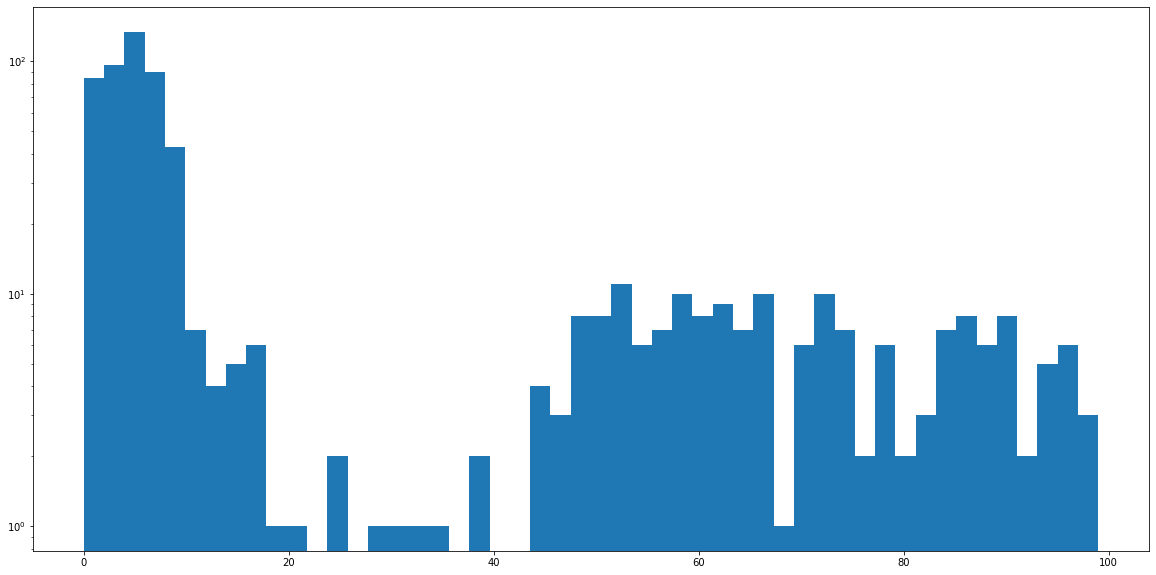

In [287]:
difference_sec = df_cys_sorted['difference_sec']

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=20,10
plt.hist(difference_sec.loc[difference_sec < 100], bins = 50)
plt.yscale("log")
plt.show()

Seems threshold 40 seconds is a sweet spot. We will treat all photos (sets of them) that are less than 40 seconds apart to be a single group.

In [288]:
group_id = 0
for i, row in df_cys_sorted.iterrows():
    diff_sec = row['difference_sec']
    if diff_sec > 40:
        group_id = group_id + 1
    df_cys_sorted.at[i, 'group'] = group_id

In [289]:
df_cys_sorted[130:155]

,measurementId,measurementSetId,measurementComment,measurementDateCreated,measurementDateFinished,receivedImagesCount,deviceId,deviceName,images_paths_list,patient_id,...,numberInSequence,analyzeDateCreated,analyzePatientId,analyzeScannedBodyPartId,analyzeDoctorComment,analyzeDiagnosisComment,LesionCode,code,difference_sec,group
672,664,c89155b03f47087c5bfed0a6a3f9cd34,NaN,2019-01-21 12:02:43,2019-01-21 10:02:43,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/664/in/...,664,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,102
979,665,ca8545a1b1bd3df45ab08409b23c6513,NaN,2019-01-21 12:03:44,2019-01-21 10:03:44,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/665/in/...,665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.0,103
797,666,2805f28d36a10f39bde11dd4813bbe39,NaN,2019-01-21 12:03:47,2019-01-21 10:03:47,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/666/in/...,666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,103
187,671,c4d0525ab4d947ba28c8c5e93529e5c9,NaN,2019-01-21 14:06:31,2019-01-21 12:06:31,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/671/in/...,671,...,19.0,2019-01-22 10:41:20,60.0,2.0,NaN,NaN,NaN,NaN,7364.0,104
452,672,d5c2a0a417536e96d47cbe2186be8a9a,NaN,2019-01-21 14:06:33,2019-01-21 12:06:33,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/672/in/...,672,...,20.0,2019-01-22 10:41:20,60.0,2.0,NaN,NaN,NaN,NaN,2.0,104
7,673,49da338725a504723b7b8ce535d41508,NaN,2019-01-21 14:08:44,2019-01-21 12:08:44,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/673/in/...,673,...,21.0,2019-01-22 10:41:20,60.0,2.0,NaN,NaN,NaN,NaN,131.0,105
993,674,493c70d3061c0e29ca484fb280eb3e82,NaN,2019-01-21 14:08:47,2019-01-21 12:08:47,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/674/in/...,674,...,22.0,2019-01-22 10:41:20,60.0,2.0,NaN,NaN,NaN,NaN,3.0,105
694,675,a9c1c743bc9bfdf0ec6a828578a26234,NaN,2019-01-21 14:17:28,2019-01-21 12:17:28,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/675/in/...,675,...,23.0,2019-01-22 10:41:20,60.0,2.0,NaN,NaN,NaN,NaN,521.0,106
464,676,5f48a34f43f4b44a37f65f09b334051e,NaN,2019-01-21 14:17:33,2019-01-21 12:17:33,10,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/676/in/...,676,...,24.0,2019-01-22 10:41:20,60.0,2.0,NaN,NaN,NaN,NaN,5.0,106
280,681,4ece53a18dfc18e3f00245b3ddfc5bed,NaN,2019-01-21 15:08:45,2019-01-21 13:08:45,3,2,Hungary,[/mnt/data/raw/_melanoma/Checkyourskin/681/in/...,681,...,25.0,2019-01-22 10:41:20,60.0,2.0,NaN,NaN,NaN,NaN,3072.0,107


### COPY FILES (Checkyourskin)

In [332]:
# Let's see stats
df_cys_sorted_gr = df_cys_sorted.groupby(['analyzePatientId','group'])
freq_dict = {}

for key, item in df_cys_sorted_gr:
    print('KEY:', key)
    l = df_cys_sorted_gr.get_group(key)['images_paths_list'].tolist()
    print('LENGTH:', len(l))
    
    if str(len(l)) not in freq_dict:
        freq_dict[str(len(l))] = 0
    
    freq_dict[str(len(l))] = freq_dict[str(len(l))] + 1
    
    
    dates = df_cys_sorted_gr.get_group(key)['measurementDateCreated'].tolist()
    print(dates)
    
    comments = df_cys_sorted_gr.get_group(key)['analyzeDoctorComment'].tolist()
    print(comments)
    
    print(l, "\n\n")
    print('==============================================')

KEY: (49.0, -1)
LENGTH: 1
['2019-01-10 16:59:51']
[nan]
[['/mnt/data/raw/_melanoma/Checkyourskin/517/in/R.png', '/mnt/data/raw/_melanoma/Checkyourskin/517/in/IR.png', '/mnt/data/raw/_melanoma/Checkyourskin/517/in/G.png']] 


KEY: (52.0, -1)
LENGTH: 2
['2019-01-21 10:53:00', '2019-01-21 10:53:03']
['dysplasticus naevus', 'dysplasticus naevus']
[['/mnt/data/raw/_melanoma/Checkyourskin/643/in/R.png', '/mnt/data/raw/_melanoma/Checkyourskin/643/in/IR.png', '/mnt/data/raw/_melanoma/Checkyourskin/643/in/G.png'], ['/mnt/data/raw/_melanoma/Checkyourskin/644/in/16.png', '/mnt/data/raw/_melanoma/Checkyourskin/644/in/13.png', '/mnt/data/raw/_melanoma/Checkyourskin/644/in/12.png', '/mnt/data/raw/_melanoma/Checkyourskin/644/in/39.png', '/mnt/data/raw/_melanoma/Checkyourskin/644/in/11.png', '/mnt/data/raw/_melanoma/Checkyourskin/644/in/14.png', '/mnt/data/raw/_melanoma/Checkyourskin/644/in/38.png', '/mnt/data/raw/_melanoma/Checkyourskin/644/in/15.png', '/mnt/data/raw/_melanoma/Checkyourskin/644/in/10

KEY: (106.0, -1)
LENGTH: 2
['2019-02-07 10:53:41', '2019-02-07 10:53:49']
['basalioma on the right side of the nose', 'basalioma on the right side of the nose']
[['/mnt/data/raw/_melanoma/Checkyourskin/993/in/R.png', '/mnt/data/raw/_melanoma/Checkyourskin/993/in/IR.png', '/mnt/data/raw/_melanoma/Checkyourskin/993/in/G.png'], ['/mnt/data/raw/_melanoma/Checkyourskin/994/in/16.png', '/mnt/data/raw/_melanoma/Checkyourskin/994/in/13.png', '/mnt/data/raw/_melanoma/Checkyourskin/994/in/12.png', '/mnt/data/raw/_melanoma/Checkyourskin/994/in/39.png', '/mnt/data/raw/_melanoma/Checkyourskin/994/in/11.png', '/mnt/data/raw/_melanoma/Checkyourskin/994/in/14.png', '/mnt/data/raw/_melanoma/Checkyourskin/994/in/38.png', '/mnt/data/raw/_melanoma/Checkyourskin/994/in/15.png', '/mnt/data/raw/_melanoma/Checkyourskin/994/in/10.png', '/mnt/data/raw/_melanoma/Checkyourskin/994/in/17.png']] 


KEY: (107.0, -1)
LENGTH: 2
['2019-02-06 10:30:53', '2019-02-06 10:30:58']
['seborrheic keratosis on the top of the hea

KEY: (168.0, -1)
LENGTH: 2
['2019-03-05 12:15:39', '2019-03-05 12:15:47']
['melanoma in situ, right side of abdomen', 'melanoma in situ, right side of abdomen']
[['/mnt/data/raw/_melanoma/Checkyourskin/1358/in/R.png', '/mnt/data/raw/_melanoma/Checkyourskin/1358/in/IR.png', '/mnt/data/raw/_melanoma/Checkyourskin/1358/in/G.png'], ['/mnt/data/raw/_melanoma/Checkyourskin/1359/in/16.png', '/mnt/data/raw/_melanoma/Checkyourskin/1359/in/13.png', '/mnt/data/raw/_melanoma/Checkyourskin/1359/in/12.png', '/mnt/data/raw/_melanoma/Checkyourskin/1359/in/39.png', '/mnt/data/raw/_melanoma/Checkyourskin/1359/in/11.png', '/mnt/data/raw/_melanoma/Checkyourskin/1359/in/14.png', '/mnt/data/raw/_melanoma/Checkyourskin/1359/in/38.png', '/mnt/data/raw/_melanoma/Checkyourskin/1359/in/15.png', '/mnt/data/raw/_melanoma/Checkyourskin/1359/in/10.png', '/mnt/data/raw/_melanoma/Checkyourskin/1359/in/17.png']] 


KEY: (169.0, -1)
LENGTH: 6
['2019-03-05 12:38:06', '2019-03-05 12:38:14', '2019-03-05 12:39:29', '2019-03

LENGTH: 2
['2019-04-11 12:04:41', '2019-04-11 12:04:47']
['naevus on the right leg', 'naevus on the right leg']
[['/mnt/data/raw/_melanoma/Checkyourskin/1879/in/R.png', '/mnt/data/raw/_melanoma/Checkyourskin/1879/in/IR.png', '/mnt/data/raw/_melanoma/Checkyourskin/1879/in/G.png'], ['/mnt/data/raw/_melanoma/Checkyourskin/1880/in/16.png', '/mnt/data/raw/_melanoma/Checkyourskin/1880/in/13.png', '/mnt/data/raw/_melanoma/Checkyourskin/1880/in/12.png', '/mnt/data/raw/_melanoma/Checkyourskin/1880/in/39.png', '/mnt/data/raw/_melanoma/Checkyourskin/1880/in/11.png', '/mnt/data/raw/_melanoma/Checkyourskin/1880/in/14.png', '/mnt/data/raw/_melanoma/Checkyourskin/1880/in/38.png', '/mnt/data/raw/_melanoma/Checkyourskin/1880/in/15.png', '/mnt/data/raw/_melanoma/Checkyourskin/1880/in/10.png', '/mnt/data/raw/_melanoma/Checkyourskin/1880/in/17.png']] 


KEY: (228.0, -1)
LENGTH: 10
['2019-04-11 12:42:32', '2019-04-11 12:42:42', '2019-04-11 12:44:11', '2019-04-11 12:44:14', '2019-04-11 12:45:06', '2019-04-1

In [291]:
freq_dict

{'1': 82, '2': 411, '4': 17, '3': 3}

{'1': 82, '2': 429, '3': 1, '4': 1}
Means that we have 82 sets of photos taken either in UV or in R+G+IR
and 429 sets of photos taken both in UV and R+G+IR 

Let's check that among those 429 there are always UV and R+G+IR sets.


In [292]:
df_cys_sorted_gr = df_cys_sorted.groupby(['analyzePatientId','group'])


def get_colors(list_of_paths):
    '''
    this function just gets list of paths, extracts pure filenames
    and then looks for files starting with R / IR / G / UV or number / white and counts them
    other filenames are just printed.
    
    It basically returns frequencies of images colors based on files names.
    '''
    freq_dict = {'r': 0, 'g': 0, 'ir': 0, 'uv':0}
    for l in list_of_paths:
        name = os.path.basename(l)
        if name.lower().startswith('r'):
            freq_dict['r'] = freq_dict['r'] + 1
        elif name.lower().startswith('g'):
            freq_dict['g'] = freq_dict['g'] + 1
        elif name.lower().startswith('ir'):
            freq_dict['ir'] = freq_dict['ir'] + 1
        elif name.lower().startswith('uv'):
            freq_dict['uv'] = freq_dict['uv'] + 1
        elif name[0:1].isnumeric():
            freq_dict['uv'] = freq_dict['uv'] + 1
            
    return freq_dict

dicts_list = []
for key, item in df_cys_sorted_gr:
    l = df_cys_sorted_gr.get_group(key)['images_paths_list'].tolist()
    if len(l) == 2:
        colors_freq = {}
        for key2, item2 in df_cys_sorted_gr.get_group(key).iterrows():
            files_paths = item2['images_paths_list']
            colors_freq.update(get_colors(files_paths))
        dicts_list.append(colors_freq)  


In [293]:
if '2' in str(dicts_list) or '3' in str(dicts_list) or '4' in str(dicts_list) or '5' in str(dicts_list):
    print('We have a problem - multiple UV or R/IR/G images!!!!')
else:
    print('All good!')

All good!


In [296]:
from tqdm.notebook import tqdm
    
def collect_grouped_file_paths_cys(df_cys_sorted):
    from datetime import datetime
    date_time_format = '%Y-%m-%d %H:%M:%S'
    
    def get_colors(list_of_lists_of_paths):
        '''
        this function just gets list of paths, extracts pure filenames
        and then looks for files starting with R / IR / G / UV or number / white and counts them
        other filenames are just printed.

        It basically returns frequencies of images colors based on files names.
        '''
        full_freq = {'r': 0, 'g': 0, 'ir': 0, 'uv':0, 'white': 0}
        dict_list = []
        bad_list_flag = False
        for lst in list_of_lists_of_paths:
            freq_dict = {'r': 0, 'g': 0, 'ir': 0, 'uv':0, 'white': 0}
            for l in lst:
                name = os.path.basename(l)
                if name.lower().startswith('r'):
                    freq_dict['r'] = freq_dict['r'] + 1
                    full_freq['r'] = full_freq['r'] + 1
                elif name.lower().startswith('g'):
                    freq_dict['g'] = freq_dict['g'] + 1
                    full_freq['g'] = full_freq['g'] + 1
                elif name.lower().startswith('ir'):
                    freq_dict['ir'] = freq_dict['ir'] + 1
                    full_freq['ir'] = full_freq['ir'] + 1
                elif name.lower().startswith('white'):
                    freq_dict['white'] = freq_dict['white'] + 1
                    full_freq['white'] = full_freq['white'] + 1
                elif name.lower().startswith('uv'):
                    freq_dict['uv'] = freq_dict['uv'] + 1
                    full_freq['uv'] = full_freq['uv'] + 1
                elif name[0:1].isnumeric():
                    freq_dict['uv'] = freq_dict['uv'] + 1
                    full_freq['uv'] = full_freq['uv'] + 1
                else:
                    print('no match! ', l)
                    bad_list_flag = True
            dict_list.append(freq_dict)
        return full_freq, dict_list, bad_list_flag
    
    def __extract_non_uv_files_paths(files_list):
        d = dict()
        for f_path in files_list:
#             print('2', l)
            f = os.path.basename(f_path)
            if f.lower().startswith('r'):
                d['r'] = f_path
            elif f.lower().startswith('ir'):
                d['ir'] = f_path
            elif f.lower().startswith('g'):
                d['g'] = f_path
            elif f.lower().startswith('white'):
                d['white'] = f_path
            else:
                print('unknown file type (R/IR/G):', f)
        return d

    root_folders = dict()
    group_from = df_cys_sorted['group'].min()
    group_to = df_cys_sorted['group'].max() + 1
    for i in tqdm(range(group_from, group_to)):
        group = df_cys_sorted.loc[df_cys_sorted['group'] == i]
        print('------------------------------------------------------------------------')
        print('group.shape', group.shape)
        try:
            files_list = group['images_paths_list'].tolist()
#             print(files_list)
            print('files_list', files_list)
            col_freq, dict_list, bad_list_flag = get_colors(files_list)

            if bad_list_flag == False:

                i = 0

                non_uv_files_paths = None
                non_uv_correlation_id = None
                uv_files_paths = None
                uv_correlation_id = None
                code = None
                orig_parent_folder = None
                created_date = None

                for i in range(len(files_list)):
                    file_group = files_list[i]
                    file_group_col_freq = dict_list[i]
                    group_index = group.index[i] 
                    if file_group_col_freq['r'] > 0 and file_group_col_freq['g'] > 0 and file_group_col_freq['ir'] > 0:
                        non_uv_files_paths = __extract_non_uv_files_paths(file_group)
                        non_uv_correlation_id = group.at[group_index, 'measurementSetId']
                        orig_parent_folder = Path(Path(file_group[0]).parent).parent
                    else:
                        print('file_group', file_group)
                        uv_files_paths = file_group
                        uv_correlation_id = group.at[group_index, 'measurementSetId']
                        orig_parent_folder = Path(Path(file_group[0]).parent).parent

                    code_series = group['code'].unique().tolist()
                    print('code_series', code_series)

                    if ('') in code_series: 
                        code_series.remove('')
                    if ('-') in code_series: 
                        code_series.remove('-')

                    if len(code_series) == 0:
                        code = 'benign'
                    elif len(code_series) == 1:
                        code = code_series[0]
                    else:
                        print('ERROR Multiple codes!!!!', code_series)
                    i = i + 1
                    
                    new_created_date = datetime.strptime(group['measurementDateCreated'].tolist()[0], date_time_format)
                    if created_date is None:
                        created_date = new_created_date
                    else:
                        created_date = min(created_date, new_created_date)

                root_folders[orig_parent_folder]= {'codes': [code]}
                if uv_files_paths is not None:
                    root_folders[orig_parent_folder].update(**{'uv': uv_files_paths, 'uv_corr_id': uv_correlation_id})
                if non_uv_files_paths is not None:
                    root_folders[orig_parent_folder].update(**non_uv_files_paths, **{'non_uv_corr_id': non_uv_correlation_id})
                
                root_folders[orig_parent_folder].update(**{'datetime': created_date.strftime('%Y-%m-%d_%H-%M-%S')})
                
        except Exception as e: 
            print(e)
    return root_folders

In [297]:
root_folders = collect_grouped_file_paths_cys(df_cys_sorted)

------------------------------------------------------------------------
group.shape (1, 23)
files_list [['/mnt/data/raw/_melanoma/Checkyourskin/306/in/R.png', '/mnt/data/raw/_melanoma/Checkyourskin/306/in/IR.png', '/mnt/data/raw/_melanoma/Checkyourskin/306/in/G.png']]
code_series [nan]
------------------------------------------------------------------------
group.shape (1, 23)
files_list [['/mnt/data/raw/_melanoma/Checkyourskin/307/in/R.png', '/mnt/data/raw/_melanoma/Checkyourskin/307/in/IR.png', '/mnt/data/raw/_melanoma/Checkyourskin/307/in/G.png']]
code_series [nan]
------------------------------------------------------------------------
group.shape (2, 23)
files_list [['/mnt/data/raw/_melanoma/Checkyourskin/308/in/R.png', '/mnt/data/raw/_melanoma/Checkyourskin/308/in/IR.png', '/mnt/data/raw/_melanoma/Checkyourskin/308/in/G.png'], ['/mnt/data/raw/_melanoma/Checkyourskin/309/in/R.png', '/mnt/data/raw/_melanoma/Checkyourskin/309/in/IR.png', '/mnt/data/raw/_melanoma/Checkyourskin/309/i

code_series [nan]
------------------------------------------------------------------------
group.shape (1, 23)
files_list [['/mnt/data/raw/_melanoma/Checkyourskin/481/in/a_09-32-07_936.png', '/mnt/data/raw/_melanoma/Checkyourskin/481/in/a_09-32-29_942.png', '/mnt/data/raw/_melanoma/Checkyourskin/481/in/a_09-32-40_946.png']]
no match!  /mnt/data/raw/_melanoma/Checkyourskin/481/in/a_09-32-07_936.png
no match!  /mnt/data/raw/_melanoma/Checkyourskin/481/in/a_09-32-29_942.png
no match!  /mnt/data/raw/_melanoma/Checkyourskin/481/in/a_09-32-40_946.png
------------------------------------------------------------------------
group.shape (1, 23)
files_list [['/mnt/data/raw/_melanoma/Checkyourskin/482/in/a_09-32-07_936.png', '/mnt/data/raw/_melanoma/Checkyourskin/482/in/a_09-32-29_942.png', '/mnt/data/raw/_melanoma/Checkyourskin/482/in/a_09-32-40_946.png']]
no match!  /mnt/data/raw/_melanoma/Checkyourskin/482/in/a_09-32-07_936.png
no match!  /mnt/data/raw/_melanoma/Checkyourskin/482/in/a_09-32-29

------------------------------------------------------------------------
group.shape (2, 23)
files_list [['/mnt/data/raw/_melanoma/Checkyourskin/738/in/R.png', '/mnt/data/raw/_melanoma/Checkyourskin/738/in/IR.png', '/mnt/data/raw/_melanoma/Checkyourskin/738/in/G.png'], ['/mnt/data/raw/_melanoma/Checkyourskin/739/in/16.png', '/mnt/data/raw/_melanoma/Checkyourskin/739/in/13.png', '/mnt/data/raw/_melanoma/Checkyourskin/739/in/12.png', '/mnt/data/raw/_melanoma/Checkyourskin/739/in/39.png', '/mnt/data/raw/_melanoma/Checkyourskin/739/in/11.png', '/mnt/data/raw/_melanoma/Checkyourskin/739/in/14.png', '/mnt/data/raw/_melanoma/Checkyourskin/739/in/38.png', '/mnt/data/raw/_melanoma/Checkyourskin/739/in/15.png', '/mnt/data/raw/_melanoma/Checkyourskin/739/in/10.png', '/mnt/data/raw/_melanoma/Checkyourskin/739/in/17.png']]
code_series [nan]
file_group ['/mnt/data/raw/_melanoma/Checkyourskin/739/in/16.png', '/mnt/data/raw/_melanoma/Checkyourskin/739/in/13.png', '/mnt/data/raw/_melanoma/Checkyourskin

------------------------------------------------------------------------
group.shape (2, 23)
files_list [['/mnt/data/raw/_melanoma/Checkyourskin/955/in/R.png', '/mnt/data/raw/_melanoma/Checkyourskin/955/in/IR.png', '/mnt/data/raw/_melanoma/Checkyourskin/955/in/G.png'], ['/mnt/data/raw/_melanoma/Checkyourskin/956/in/16.png', '/mnt/data/raw/_melanoma/Checkyourskin/956/in/13.png', '/mnt/data/raw/_melanoma/Checkyourskin/956/in/12.png', '/mnt/data/raw/_melanoma/Checkyourskin/956/in/39.png', '/mnt/data/raw/_melanoma/Checkyourskin/956/in/11.png', '/mnt/data/raw/_melanoma/Checkyourskin/956/in/14.png', '/mnt/data/raw/_melanoma/Checkyourskin/956/in/38.png', '/mnt/data/raw/_melanoma/Checkyourskin/956/in/15.png', '/mnt/data/raw/_melanoma/Checkyourskin/956/in/10.png', '/mnt/data/raw/_melanoma/Checkyourskin/956/in/17.png']]
code_series ['L82']
file_group ['/mnt/data/raw/_melanoma/Checkyourskin/956/in/16.png', '/mnt/data/raw/_melanoma/Checkyourskin/956/in/13.png', '/mnt/data/raw/_melanoma/Checkyoursk

------------------------------------------------------------------------
group.shape (2, 23)
files_list [['/mnt/data/raw/_melanoma/Checkyourskin/1187/in/R.png', '/mnt/data/raw/_melanoma/Checkyourskin/1187/in/IR.png', '/mnt/data/raw/_melanoma/Checkyourskin/1187/in/G.png'], ['/mnt/data/raw/_melanoma/Checkyourskin/1188/in/16.png', '/mnt/data/raw/_melanoma/Checkyourskin/1188/in/13.png', '/mnt/data/raw/_melanoma/Checkyourskin/1188/in/12.png', '/mnt/data/raw/_melanoma/Checkyourskin/1188/in/39.png', '/mnt/data/raw/_melanoma/Checkyourskin/1188/in/11.png', '/mnt/data/raw/_melanoma/Checkyourskin/1188/in/14.png', '/mnt/data/raw/_melanoma/Checkyourskin/1188/in/38.png', '/mnt/data/raw/_melanoma/Checkyourskin/1188/in/15.png', '/mnt/data/raw/_melanoma/Checkyourskin/1188/in/10.png', '/mnt/data/raw/_melanoma/Checkyourskin/1188/in/17.png']]
code_series ['C44']
file_group ['/mnt/data/raw/_melanoma/Checkyourskin/1188/in/16.png', '/mnt/data/raw/_melanoma/Checkyourskin/1188/in/13.png', '/mnt/data/raw/_melan

------------------------------------------------------------------------
group.shape (2, 23)
files_list [['/mnt/data/raw/_melanoma/Checkyourskin/1418/in/R.png', '/mnt/data/raw/_melanoma/Checkyourskin/1418/in/IR.png', '/mnt/data/raw/_melanoma/Checkyourskin/1418/in/G.png'], ['/mnt/data/raw/_melanoma/Checkyourskin/1419/in/16.png', '/mnt/data/raw/_melanoma/Checkyourskin/1419/in/13.png', '/mnt/data/raw/_melanoma/Checkyourskin/1419/in/12.png', '/mnt/data/raw/_melanoma/Checkyourskin/1419/in/39.png', '/mnt/data/raw/_melanoma/Checkyourskin/1419/in/11.png', '/mnt/data/raw/_melanoma/Checkyourskin/1419/in/14.png', '/mnt/data/raw/_melanoma/Checkyourskin/1419/in/38.png', '/mnt/data/raw/_melanoma/Checkyourskin/1419/in/15.png', '/mnt/data/raw/_melanoma/Checkyourskin/1419/in/10.png', '/mnt/data/raw/_melanoma/Checkyourskin/1419/in/17.png']]
code_series ['L98.8']
file_group ['/mnt/data/raw/_melanoma/Checkyourskin/1419/in/16.png', '/mnt/data/raw/_melanoma/Checkyourskin/1419/in/13.png', '/mnt/data/raw/_mel

code_series ['D22']
file_group ['/mnt/data/raw/_melanoma/Checkyourskin/1566/in/16.png', '/mnt/data/raw/_melanoma/Checkyourskin/1566/in/13.png', '/mnt/data/raw/_melanoma/Checkyourskin/1566/in/12.png', '/mnt/data/raw/_melanoma/Checkyourskin/1566/in/39.png', '/mnt/data/raw/_melanoma/Checkyourskin/1566/in/11.png', '/mnt/data/raw/_melanoma/Checkyourskin/1566/in/14.png', '/mnt/data/raw/_melanoma/Checkyourskin/1566/in/38.png', '/mnt/data/raw/_melanoma/Checkyourskin/1566/in/15.png', '/mnt/data/raw/_melanoma/Checkyourskin/1566/in/10.png', '/mnt/data/raw/_melanoma/Checkyourskin/1566/in/17.png']
code_series ['D22']
------------------------------------------------------------------------
group.shape (2, 23)
files_list [['/mnt/data/raw/_melanoma/Checkyourskin/1586/in/R.png', '/mnt/data/raw/_melanoma/Checkyourskin/1586/in/IR.png', '/mnt/data/raw/_melanoma/Checkyourskin/1586/in/G.png'], ['/mnt/data/raw/_melanoma/Checkyourskin/1587/in/16.png', '/mnt/data/raw/_melanoma/Checkyourskin/1587/in/13.png', '/

------------------------------------------------------------------------
group.shape (2, 23)
files_list [['/mnt/data/raw/_melanoma/Checkyourskin/1826/in/R.png', '/mnt/data/raw/_melanoma/Checkyourskin/1826/in/IR.png', '/mnt/data/raw/_melanoma/Checkyourskin/1826/in/G.png'], ['/mnt/data/raw/_melanoma/Checkyourskin/1827/in/16.png', '/mnt/data/raw/_melanoma/Checkyourskin/1827/in/13.png', '/mnt/data/raw/_melanoma/Checkyourskin/1827/in/12.png', '/mnt/data/raw/_melanoma/Checkyourskin/1827/in/39.png', '/mnt/data/raw/_melanoma/Checkyourskin/1827/in/11.png', '/mnt/data/raw/_melanoma/Checkyourskin/1827/in/14.png', '/mnt/data/raw/_melanoma/Checkyourskin/1827/in/38.png', '/mnt/data/raw/_melanoma/Checkyourskin/1827/in/15.png', '/mnt/data/raw/_melanoma/Checkyourskin/1827/in/10.png', '/mnt/data/raw/_melanoma/Checkyourskin/1827/in/17.png']]
code_series ['PXE']
file_group ['/mnt/data/raw/_melanoma/Checkyourskin/1827/in/16.png', '/mnt/data/raw/_melanoma/Checkyourskin/1827/in/13.png', '/mnt/data/raw/_melan

In [ ]:
# root_folders

In [468]:
target_cys_img_folder = os.path.abspath('../../data/interim/_melanoma_20200728_2/checkyourskin')
target_cys_img_folder

'/mnt/data/interim/_melanoma_20200728_2/checkyourskin'

In [469]:
root_folders

{PosixPath('/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5'): {'codes': ['D48',
   'D48'],
  'r': '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2643.tar/in/R_1ms.png',
  'white': '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2643.tar/in/White_6ms.png',
  'g': '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2643.tar/in/G_6ms.png',
  'ir': '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2643.tar/in/IR_3ms.png',
  'non_uv_corr_id': '49e43a7cf5fcb6a1244253894db4adcd',
  'datetime': '2019-07-22 11:16:19',
  'uv': ['/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV25_180ms.png',
   '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV15_180ms.png',
   '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV16_180ms.png',
   '/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV19_180ms.png',
   '/mnt/data/raw/_melanoma/M

In [470]:
import uuid
import shutil
import os
import math
import collections

from PIL import Image


for k, v in root_folders.items():
    
    print('k,v-->', k, v['codes'])
    if isinstance(v['codes'], collections.Iterable):
        if len(v['codes']) == 0:
            code = 'benign'
        else:
            _v = v['codes'][0]
            _v = str(_v).strip()
            if _v == 'None' or _v == 'nan':
                code = 'nan'
            else:
                code = _v

    else:
        code = 'na_error2'
     
    if 'r' in v:
        src_r_path = v['r']
        src_ir_path = v['ir']
        src_g_path = v['g']
        folders_list = ['r', 'ir', 'g']
        measurements_list = [v['non_uv_corr_id'], v['non_uv_corr_id'], v['non_uv_corr_id']]
    else:
        src_r_path = None
        src_g_path = None
        src_ir_path = None
        
    if 'white' in v:
        src_white_path = v['white']
        folders_list.append('white')
        measurements_list.append(v['non_uv_corr_id'])
    else:
        src_white_path = None
        
    if 'uv' in v:
        src_uv_paths = v['uv']
        folders_list.append('uv')
        measurements_list.append(v['uv_corr_id'])
    else:
        src_uv_path = None
        
    
    if src_r_path is None:
        print('R / IR / G is missing!!!')
    if src_white_path is None:
        print('White is missing!!!')
    if src_uv_paths is None:
        print('UV is missing!!!') 
    
    date_time = v['datetime']
    target_parent_folder = os.path.join(target_cys_img_folder, code, date_time)

    # prepare folders
    if src_r_path is not None:
        os.makedirs(os.path.join(target_parent_folder, 'r'))
        os.makedirs(os.path.join(target_parent_folder, 'ir'))
        os.makedirs(os.path.join(target_parent_folder, 'g'))

        shutil.copy(src_r_path, os.path.join(target_parent_folder, 'r', os.path.basename(src_r_path)))
        shutil.copy(src_ir_path, os.path.join(target_parent_folder, 'ir', os.path.basename(src_ir_path)))
        shutil.copy(src_g_path, os.path.join(target_parent_folder, 'g', os.path.basename(src_g_path)))
    if src_white_path is not None:
        os.makedirs(os.path.join(target_parent_folder, 'white'))
        shutil.copy(src_white_path, os.path.join(target_parent_folder, 'white', os.path.basename(src_white_path)))
    if src_uv_paths is not None:
        os.makedirs(os.path.join(target_parent_folder, 'uv'))
        for src_uv_path in src_uv_paths:
            uv_src = src_uv_path
            uv_dst = os.path.join(target_parent_folder, 'uv', os.path.basename(src_uv_path))
            print(' copying UV from:[{}] to:[{}]'.format(uv_src, uv_dst))
            
#             shutil.copy(uv_src, uv_dst)
            # We want not copy, but copy & rotate!
            
            #read the image
            im = Image.open(uv_src)
            #rotate image by 90 degrees
            angle = 90
            out = im.rotate(angle, expand=True)
            out.save(uv_dst)


    
    df_meta = pd.DataFrame({'measurementSetId': measurements_list, 'folder': folders_list})
    df_meta.to_csv(os.path.join(target_parent_folder, 'correlations.csv'))
    

k,v--> /mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5 ['D48', 'D48']
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV25_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D48/2019-07-22 11:16:19/uv/UV25_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV15_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D48/2019-07-22 11:16:19/uv/UV15_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV16_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D48/2019-07-22 11:16:19/uv/UV16_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642.tar/in/UV19_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D48/2019-07-22 11:16:19/uv/UV19_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/5/2642

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/4/2641.tar/in/UV28_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/C44imi/2019-07-22 11:15:20/uv/UV28_180ms.png]
k,v--> /mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/6 ['D48', 'D48']
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/6/2645.tar/in/UV25_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D48/2019-07-22 11:17:11/uv/UV25_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/6/2645.tar/in/UV15_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D48/2019-07-22 11:17:11/uv/UV15_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/6/2645.tar/in/UV16_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D48/2019-07-22 11:17:11/uv/UV16_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/6/2

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/7/2647.tar/in/UV24_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/C44imi/2019-07-22 11:18:17/uv/UV24_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/7/2647.tar/in/UV28_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/C44imi/2019-07-22 11:18:17/uv/UV28_180ms.png]
k,v--> /mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/3 ['C44imi', 'C44imi']
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/3/2639.tar/in/UV25_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/C44imi/2019-07-22 11:14:34/uv/UV25_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/3/2639.tar/in/UV15_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/C44imi/2019-07-22 11:14:34/uv/UV15_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/201

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/2/2637.tar/in/UV14_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rl/2019-07-22 11:13:36/uv/UV14_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/2/2637.tar/in/UV24_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rl/2019-07-22 11:13:36/uv/UV24_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/2/2637.tar/in/UV28_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rl/2019-07-22 11:13:36/uv/UV28_180ms.png]
k,v--> /mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/1 ['C44', 'C44']
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/1/2634.tar/in/UV25_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/C44/2019-07-22 11:12:41/uv/UV25_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_272/1/2634.ta

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-17_270/2/2583.tar/in/UV20_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/L82/2019-07-17 10:57:58/uv/UV20_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-17_270/2/2583.tar/in/UV14_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/L82/2019-07-17 10:57:58/uv/UV14_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-17_270/2/2583.tar/in/UV24_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/L82/2019-07-17 10:57:58/uv/UV24_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-17_270/2/2583.tar/in/UV28_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/L82/2019-07-17 10:57:58/uv/UV28_180ms.png]
k,v--> /mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-17_270/1 ['L82', 'L82']
White is missing!!!
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-26_275/1/2665.tar/in/UV10_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-07-26 10:17:36/uv/UV10_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-26_275/1/2665.tar/in/UV28_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-07-26 10:17:36/uv/UV28_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-26_275/1/2665.tar/in/UV13_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-07-26 10:17:36/uv/UV13_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-26_275/1/2665.tar/in/UV14_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-07-26 10:17:36/uv/UV14_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-26_275/1/2665.tar/in/UV19_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-03_260/5/2510.tar/in/UV10_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/R/2019-07-03 09:43:59/uv/UV10_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-03_260/5/2510.tar/in/UV28_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/R/2019-07-03 09:43:59/uv/UV28_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-03_260/5/2510.tar/in/UV13_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/R/2019-07-03 09:43:59/uv/UV13_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-03_260/5/2510.tar/in/UV14_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/R/2019-07-03 09:43:59/uv/UV14_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-03_260/5/2510.tar/in/UV19_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/R/2019-07-0

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-03_260/6/2512.tar/in/UV10_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/R/2019-07-03 09:46:51/uv/UV10_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-03_260/6/2512.tar/in/UV28_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/R/2019-07-03 09:46:51/uv/UV28_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-03_260/6/2512.tar/in/UV13_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/R/2019-07-03 09:46:51/uv/UV13_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-03_260/6/2512.tar/in/UV14_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/R/2019-07-03 09:46:51/uv/UV14_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-03_260/6/2512.tar/in/UV19_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/R/2019-07-0

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-03_260/3/2506.tar/in/UV10_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/R/2019-07-03 09:41:52/uv/UV10_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-03_260/3/2506.tar/in/UV28_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/R/2019-07-03 09:41:52/uv/UV28_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-03_260/3/2506.tar/in/UV13_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/R/2019-07-03 09:41:52/uv/UV13_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-03_260/3/2506.tar/in/UV14_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/R/2019-07-03 09:41:52/uv/UV14_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-03_260/3/2506.tar/in/UV19_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/R/2019-07-0

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-03_260/1/2502.tar/in/UV21_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rm/2019-07-03 09:40:08/uv/UV21_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-03_260/1/2502.tar/in/UV10_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rm/2019-07-03 09:40:08/uv/UV10_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-03_260/1/2502.tar/in/UV28_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rm/2019-07-03 09:40:08/uv/UV28_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-03_260/1/2502.tar/in/UV13_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rm/2019-07-03 09:40:08/uv/UV13_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-03_260/1/2502.tar/in/UV14_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rm/2019

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-24_273/3/2654.tar/in/UV23_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-24 09:28:58/uv/UV23_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-24_273/3/2654.tar/in/UV18_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-24 09:28:58/uv/UV18_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-24_273/3/2654.tar/in/UV20_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-24 09:28:58/uv/UV20_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-24_273/3/2654.tar/in/UV14_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-24 09:28:58/uv/UV14_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-24_273/3/2654.tar/in/UV24_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-24_273/1/2650.tar/in/UV29_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-24 09:22:17/uv/UV29_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-24_273/1/2650.tar/in/UV23_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-24 09:22:17/uv/UV23_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-24_273/1/2650.tar/in/UV18_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-24 09:22:17/uv/UV18_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-24_273/1/2650.tar/in/UV20_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-24 09:22:17/uv/UV20_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-24_273/1/2650.tar/in/UV14_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-10_267/2/2570.tar/in/UV27_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D48/2019-07-10 11:45:53/uv/UV27_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-10_267/2/2570.tar/in/UV21_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D48/2019-07-10 11:45:53/uv/UV21_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-10_267/2/2570.tar/in/UV10_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D48/2019-07-10 11:45:53/uv/UV10_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-10_267/2/2570.tar/in/UV28_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D48/2019-07-10 11:45:53/uv/UV28_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-10_267/2/2570.tar/in/UV13_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D48

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-24_274/2/2660.tar/in/UV29_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/benign/2019-07-24 09:40:54/uv/UV29_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-24_274/2/2660.tar/in/UV23_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/benign/2019-07-24 09:40:54/uv/UV23_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-24_274/2/2660.tar/in/UV18_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/benign/2019-07-24 09:40:54/uv/UV18_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-24_274/2/2660.tar/in/UV20_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/benign/2019-07-24 09:40:54/uv/UV20_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-24_274/2/2660.tar/in/UV14_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/check

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-10_266/2/2566.tar/in/UV27_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-10 11:42:23/uv/UV27_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-10_266/2/2566.tar/in/UV21_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-10 11:42:23/uv/UV21_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-10_266/2/2566.tar/in/UV10_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-10 11:42:23/uv/UV10_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-10_266/2/2566.tar/in/UV28_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-10 11:42:23/uv/UV28_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-10_266/2/2566.tar/in/UV13_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_125B/5/2617.tar/in/UV12_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D48/2019-07-22 10:23:04/uv/UV12_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_125B/5/2617.tar/in/UV27_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D48/2019-07-22 10:23:04/uv/UV27_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_125B/5/2617.tar/in/UV21_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D48/2019-07-22 10:23:04/uv/UV21_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_125B/5/2617.tar/in/UV10_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D48/2019-07-22 10:23:04/uv/UV10_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_125B/5/2617.tar/in/UV28_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourski

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_125B/1B/2626.tar/in/UV26_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-07-22 10:27:32/uv/UV26_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_125B/1B/2626.tar/in/UV29_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-07-22 10:27:32/uv/UV29_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_125B/1B/2626.tar/in/UV23_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-07-22 10:27:32/uv/UV23_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_125B/1B/2626.tar/in/UV18_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-07-22 10:27:32/uv/UV18_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_125B/1B/2626.tar/in/UV20_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyoursk

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_125B/3.2B/2625.tar/in/UV12_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-07-22 10:26:36/uv/UV12_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_125B/3.2B/2625.tar/in/UV27_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-07-22 10:26:36/uv/UV27_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_125B/3.2B/2625.tar/in/UV21_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-07-22 10:26:36/uv/UV21_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_125B/3.2B/2625.tar/in/UV10_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-07-22 10:26:36/uv/UV10_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_125B/3.2B/2625.tar/in/UV28_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/c

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_125B/2B/2628.tar/in/UV26_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-07-22 10:28:24/uv/UV26_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_125B/2B/2628.tar/in/UV29_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-07-22 10:28:24/uv/UV29_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_125B/2B/2628.tar/in/UV23_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-07-22 10:28:24/uv/UV23_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_125B/2B/2628.tar/in/UV18_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-07-22 10:28:24/uv/UV18_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-22_125B/2B/2628.tar/in/UV20_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyoursk

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-06_276B/1B/4021.tar/in/UV12_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-06 09:47:28/uv/UV12_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-06_276B/1B/4021.tar/in/UV27_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-06 09:47:28/uv/UV27_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-06_276B/1B/4021.tar/in/UV21_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-06 09:47:28/uv/UV21_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-06_276B/1B/4021.tar/in/UV10_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-06 09:47:28/uv/UV10_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-06_276B/1B/4021.tar/in/UV28_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyoursk

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-06_276B/6B/4031.tar/in/UV26_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-06 09:50:58/uv/UV26_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-06_276B/6B/4031.tar/in/UV29_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-06 09:50:58/uv/UV29_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-06_276B/6B/4031.tar/in/UV23_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-06 09:50:58/uv/UV23_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-06_276B/6B/4031.tar/in/UV18_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-06 09:50:58/uv/UV18_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-06_276B/6B/4031.tar/in/UV20_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyoursk

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-06_276B/2B/4023.tar/in/UV12_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-06 09:48:17/uv/UV12_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-06_276B/2B/4023.tar/in/UV27_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-06 09:48:17/uv/UV27_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-06_276B/2B/4023.tar/in/UV21_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-06 09:48:17/uv/UV21_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-06_276B/2B/4023.tar/in/UV10_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-06 09:48:17/uv/UV10_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-06_276B/2B/4023.tar/in/UV28_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyoursk

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-10_56C/6B/4085.tar/in/UV12_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-10 09:23:53/uv/UV12_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-10_56C/6B/4085.tar/in/UV27_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-10 09:23:53/uv/UV27_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-10_56C/6B/4085.tar/in/UV21_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-10 09:23:53/uv/UV21_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-10_56C/6B/4085.tar/in/UV10_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-10 09:23:53/uv/UV10_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-10_56C/6B/4085.tar/in/UV28_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-10_56C/8B/4089.tar/in/UV12_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-10 09:25:05/uv/UV12_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-10_56C/8B/4089.tar/in/UV27_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-10 09:25:05/uv/UV27_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-10_56C/8B/4089.tar/in/UV21_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-10 09:25:05/uv/UV21_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-10_56C/8B/4089.tar/in/UV10_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-10 09:25:05/uv/UV10_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-10_56C/8B/4089.tar/in/UV28_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-10_56C/1C/4075.tar/in/UV12_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-10 09:20:12/uv/UV12_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-10_56C/1C/4075.tar/in/UV27_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-10 09:20:12/uv/UV27_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-10_56C/1C/4075.tar/in/UV21_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-10 09:20:12/uv/UV21_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-10_56C/1C/4075.tar/in/UV10_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-10 09:20:12/uv/UV10_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-10_56C/1C/4075.tar/in/UV28_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-10_56C/7B/4087.tar/in/UV12_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-10 09:24:03/uv/UV12_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-10_56C/7B/4087.tar/in/UV27_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-10 09:24:03/uv/UV27_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-10_56C/7B/4087.tar/in/UV21_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-10 09:24:03/uv/UV21_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-10_56C/7B/4087.tar/in/UV10_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2020-01-10 09:24:03/uv/UV10_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-10_56C/7B/4087.tar/in/UV28_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_11/2019-11-11_132B/4.3B/3411.tar/in/UV12_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-11-11 12:43:35/uv/UV12_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_11/2019-11-11_132B/4.3B/3411.tar/in/UV27_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-11-11 12:43:35/uv/UV27_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_11/2019-11-11_132B/4.3B/3411.tar/in/UV21_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-11-11 12:43:35/uv/UV21_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_11/2019-11-11_132B/4.3B/3411.tar/in/UV10_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-11-11 12:43:35/uv/UV10_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_11/2019-11-11_132B/4.3B/3411.tar/in/UV28_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/c

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_11/2019-11-11_132B/5B/3413.tar/in/UV27_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-11-11 12:43:45/uv/UV27_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_11/2019-11-11_132B/5B/3413.tar/in/UV21_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-11-11 12:43:45/uv/UV21_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_11/2019-11-11_132B/5B/3413.tar/in/UV10_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-11-11 12:43:45/uv/UV10_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_11/2019-11-11_132B/5B/3413.tar/in/UV28_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-11-11 12:43:45/uv/UV28_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_11/2019-11-11_132B/5B/3413.tar/in/UV13_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyoursk

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_11/2019-11-11_132B/4.2B/3409.tar/in/UV12_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-11-11 12:42:30/uv/UV12_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_11/2019-11-11_132B/4.2B/3409.tar/in/UV27_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-11-11 12:42:30/uv/UV27_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_11/2019-11-11_132B/4.2B/3409.tar/in/UV21_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-11-11 12:42:30/uv/UV21_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_11/2019-11-11_132B/4.2B/3409.tar/in/UV10_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-11-11 12:42:30/uv/UV10_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_11/2019-11-11_132B/4.2B/3409.tar/in/UV28_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/c

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_11/2019-11-11_132B/2B/3403.tar/in/UV20_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-11-11 12:40:42/uv/UV20_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_11/2019-11-11_132B/2B/3403.tar/in/UV12_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-11-11 12:40:42/uv/UV12_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_11/2019-11-11_132B/2B/3403.tar/in/UV27_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-11-11 12:40:42/uv/UV27_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_11/2019-11-11_132B/2B/3403.tar/in/UV21_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-11-11 12:40:42/uv/UV21_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_11/2019-11-11_132B/2B/3403.tar/in/UV10_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyoursk

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_199B/1.2B/3668.tar/in/UV20_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-02 12:46:17/uv/UV20_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_199B/1.2B/3668.tar/in/UV12_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-02 12:46:17/uv/UV12_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_199B/1.2B/3668.tar/in/UV27_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-02 12:46:17/uv/UV27_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_199B/1.2B/3668.tar/in/UV21_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-02 12:46:17/uv/UV21_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_199B/1.2B/3668.tar/in/UV10_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/c

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_199B/1.1B/3666.tar/in/UV20_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-02 12:45:41/uv/UV20_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_199B/1.1B/3666.tar/in/UV12_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-02 12:45:41/uv/UV12_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_199B/1.1B/3666.tar/in/UV27_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-02 12:45:41/uv/UV27_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_199B/1.1B/3666.tar/in/UV21_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-02 12:45:41/uv/UV21_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_199B/1.1B/3666.tar/in/UV10_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/c

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/5B/3834.tar/in/UV21_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:42:28/uv/UV21_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/5B/3834.tar/in/UV26_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:42:28/uv/UV26_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/5B/3834.tar/in/UV29_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:42:28/uv/UV29_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/5B/3834.tar/in/UV23_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:42:28/uv/UV23_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/5B/3834.tar/in/UV18_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyoursk

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/6B/3836.tar/in/UV21_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:43:11/uv/UV21_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/6B/3836.tar/in/UV26_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:43:11/uv/UV26_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/6B/3836.tar/in/UV29_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:43:11/uv/UV29_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/6B/3836.tar/in/UV23_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:43:11/uv/UV23_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/6B/3836.tar/in/UV18_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyoursk

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/8B/3840.tar/in/UV21_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:44:28/uv/UV21_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/8B/3840.tar/in/UV26_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:44:28/uv/UV26_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/8B/3840.tar/in/UV29_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:44:28/uv/UV29_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/8B/3840.tar/in/UV23_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:44:28/uv/UV23_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/8B/3840.tar/in/UV18_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyoursk

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/4B/3832.tar/in/UV21_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:41:39/uv/UV21_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/4B/3832.tar/in/UV26_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:41:39/uv/UV26_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/4B/3832.tar/in/UV29_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:41:39/uv/UV29_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/4B/3832.tar/in/UV23_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:41:39/uv/UV23_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/4B/3832.tar/in/UV18_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyoursk

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/3B/3830.tar/in/UV21_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:40:56/uv/UV21_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/3B/3830.tar/in/UV26_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:40:56/uv/UV26_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/3B/3830.tar/in/UV29_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:40:56/uv/UV29_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/3B/3830.tar/in/UV23_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:40:56/uv/UV23_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/3B/3830.tar/in/UV18_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyoursk

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/9B/3842.tar/in/UV21_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:45:03/uv/UV21_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/9B/3842.tar/in/UV26_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:45:03/uv/UV26_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/9B/3842.tar/in/UV29_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:45:03/uv/UV29_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/9B/3842.tar/in/UV23_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:45:03/uv/UV23_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/9B/3842.tar/in/UV18_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyoursk

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/10B/3844.tar/in/UV21_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:45:49/uv/UV21_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/10B/3844.tar/in/UV26_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:45:49/uv/UV26_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/10B/3844.tar/in/UV29_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:45:49/uv/UV29_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/10B/3844.tar/in/UV23_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-09 12:45:49/uv/UV23_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-09_122B/10B/3844.tar/in/UV18_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checky

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_138B/1.2B/3644.tar/in/UV10_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-02 10:00:50/uv/UV10_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_138B/1.2B/3644.tar/in/UV21_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-02 10:00:50/uv/UV21_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_138B/1.2B/3644.tar/in/UV26_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-02 10:00:50/uv/UV26_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_138B/1.2B/3644.tar/in/UV29_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-02 10:00:50/uv/UV29_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_138B/1.2B/3644.tar/in/UV23_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/c

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_138B/1.1B/3642.tar/in/UV11_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-02 10:00:13/uv/UV11_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_138B/1.1B/3642.tar/in/UV10_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-02 10:00:13/uv/UV10_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_138B/1.1B/3642.tar/in/UV21_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-02 10:00:13/uv/UV21_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_138B/1.1B/3642.tar/in/UV26_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-02 10:00:13/uv/UV26_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_138B/1.1B/3642.tar/in/UV29_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/c

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_138B/3B/3660.tar/in/UV17_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-02 10:06:57/uv/UV17_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_138B/3B/3660.tar/in/UV20_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-02 10:06:57/uv/UV20_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_138B/3B/3660.tar/in/UV12_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-02 10:06:57/uv/UV12_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_138B/3B/3660.tar/in/UV27_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-12-02 10:06:57/uv/UV27_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_12/2019-12-02_138B/3B/3660.tar/in/UV21_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyoursk

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-14_94B/11B/2738.tar/in/UV11_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-14 10:42:02/uv/UV11_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-14_94B/11B/2738.tar/in/UV10_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-14 10:42:02/uv/UV10_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-14_94B/11B/2738.tar/in/UV21_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-14 10:42:02/uv/UV21_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-14_94B/11B/2738.tar/in/UV26_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-14 10:42:02/uv/UV26_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-14_94B/11B/2738.tar/in/UV29_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyoursk

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-14_94B/10B/2736.tar/in/UV17_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-14 10:41:47/uv/UV17_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-14_94B/10B/2736.tar/in/UV11_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-14 10:41:47/uv/UV11_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-14_94B/10B/2736.tar/in/UV10_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-14 10:41:47/uv/UV10_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-14_94B/10B/2736.tar/in/UV21_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-14 10:41:47/uv/UV21_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-14_94B/10B/2736.tar/in/UV26_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyoursk

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-19_110B/5B/2782.tar/in/UV15_333ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-19 11:59:01/uv/UV15_333ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-19_110B/5B/2782.tar/in/UV21_333ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-19 11:59:01/uv/UV21_333ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-19_110B/5B/2782.tar/in/UV28_333ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-19 11:59:01/uv/UV28_333ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-19_110B/5B/2782.tar/in/UV13_333ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-19 11:59:01/uv/UV13_333ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-19_110B/5B/2782.tar/in/UV29_333ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyoursk

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-19_110B/2B/2774.tar/in/UV24_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-19 11:55:24/uv/UV24_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-19_110B/2B/2774.tar/in/UV11_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-19 11:55:24/uv/UV11_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-19_110B/2B/2774.tar/in/UV17_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-19 11:55:24/uv/UV17_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-19_110B/2B/2774.tar/in/UV20_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-19 11:55:24/uv/UV20_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-19_110B/2B/2774.tar/in/UV12_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyoursk

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-05_206B/1_5/2698.tar/in/UV24_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-05 11:41:03/uv/UV24_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-05_206B/1_5/2698.tar/in/UV11_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-05 11:41:03/uv/UV11_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-05_206B/1_5/2698.tar/in/UV17_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-05 11:41:03/uv/UV17_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-05_206B/1_5/2698.tar/in/UV20_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-05 11:41:03/uv/UV20_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-05_206B/1_5/2698.tar/in/UV12_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checky

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-05_206B/1_4/2696.tar/in/UV26_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-05 11:39:58/uv/UV26_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-05_206B/1_4/2696.tar/in/UV24_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-05 11:39:58/uv/UV24_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-05_206B/1_4/2696.tar/in/UV11_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-05 11:39:58/uv/UV11_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-05_206B/1_4/2696.tar/in/UV17_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-05 11:39:58/uv/UV17_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-05_206B/1_4/2696.tar/in/UV20_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checky

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-05_206B/1_1/2690.tar/in/UV26_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-05 11:38:15/uv/UV26_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-05_206B/1_1/2690.tar/in/UV24_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-05 11:38:15/uv/UV24_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-05_206B/1_1/2690.tar/in/UV11_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-05 11:38:15/uv/UV11_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-05_206B/1_1/2690.tar/in/UV17_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rb/2019-08-05 11:38:15/uv/UV17_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_08/2019-08-05_206B/1_1/2690.tar/in/UV20_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checky

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_265/4/2552.tar/in/UV12_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D23/2019-07-10 10:14:24/uv/UV12_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_265/4/2552.tar/in/UV17_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D23/2019-07-10 10:14:24/uv/UV17_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_265/4/2552.tar/in/UV11_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D23/2019-07-10 10:14:24/uv/UV11_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_265/4/2552.tar/in/UV10_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D23/2019-07-10 10:14:24/uv/UV10_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_265/4/2552.tar/in/UV21_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D23

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_265/2/2548.tar/in/UV12_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-10 10:12:59/uv/UV12_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_265/2/2548.tar/in/UV17_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-10 10:12:59/uv/UV17_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_265/2/2548.tar/in/UV11_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-10 10:12:59/uv/UV11_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_265/2/2548.tar/in/UV10_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-10 10:12:59/uv/UV10_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_265/2/2548.tar/in/UV21_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-12_268/3/2578.tar/in/UV13_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/L82/2019-07-12 10:12:00/uv/UV13_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-12_268/3/2578.tar/in/UV12_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/L82/2019-07-12 10:12:00/uv/UV12_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-12_268/3/2578.tar/in/UV17_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/L82/2019-07-12 10:12:00/uv/UV17_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-12_268/3/2578.tar/in/UV11_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/L82/2019-07-12 10:12:00/uv/UV11_180ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-12_268/3/2578.tar/in/UV10_180ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/L82

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-12_268/1/2574.tar/in/UV15_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/C44/2019-07-12 10:10:12/uv/UV15_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-12_268/1/2574.tar/in/UV26_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/C44/2019-07-12 10:10:12/uv/UV26_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-12_268/1/2574.tar/in/UV24_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/C44/2019-07-12 10:10:12/uv/UV24_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-12_268/1/2574.tar/in/UV11_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/C44/2019-07-12 10:10:12/uv/UV11_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-12_268/1/2574.tar/in/UV17_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/C44

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_264/Jaunais/4/2528.tar/in/UV29_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-05 11:33:46/uv/UV29_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_264/Jaunais/4/2528.tar/in/UV16_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-05 11:33:46/uv/UV16_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_264/Jaunais/4/2528.tar/in/UV15_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-05 11:33:46/uv/UV15_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_264/Jaunais/4/2528.tar/in/UV26_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-05 11:33:46/uv/UV26_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_264/Jaunais/4/2528.tar/in/UV24_300ms.png] to:[/mnt/data/interi

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_264/Jaunais/3/2526.tar/in/UV18_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rm/2019-07-05 11:32:58/uv/UV18_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_264/Jaunais/3/2526.tar/in/UV25_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rm/2019-07-05 11:32:58/uv/UV25_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_264/Jaunais/3/2526.tar/in/UV29_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rm/2019-07-05 11:32:58/uv/UV29_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_264/Jaunais/3/2526.tar/in/UV16_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/Rm/2019-07-05 11:32:58/uv/UV16_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_264/Jaunais/3/2526.tar/in/UV15_300ms.png] to:[/mnt/data/interim/_m

k,v--> /mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_264/Jaunais/1 ['D22', 'D22']
White is missing!!!
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_264/Jaunais/1/2522.tar/in/UV23_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-05 11:31:23/uv/UV23_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_264/Jaunais/1/2522.tar/in/UV22_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-05 11:31:23/uv/UV22_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_264/Jaunais/1/2522.tar/in/UV18_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-05 11:31:23/uv/UV18_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2019_07/2019-07-05_264/Jaunais/1/2522.tar/in/UV25_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D22/2019-07-05 11:31:23/uv/UV25_300ms.png]
 copying UV from:[/mnt/d

 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-06_9B/3/4041.tar/in/UV14_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D48/2020-01-06 10:13:26/uv/UV14_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-06_9B/3/4041.tar/in/UV19_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/D48/2020-01-06 10:13:26/uv/UV19_300ms.png]
k,v--> /mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-13_326/4 ['L81', 'L81']
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-13_326/4/4131.tar/in/UV23_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/L81/2020-01-13 10:03:37/uv/UV23_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-13_326/4/4131.tar/in/UV22_300ms.png] to:[/mnt/data/interim/_melanoma_20200728_2/checkyourskin/L81/2020-01-13 10:03:37/uv/UV22_300ms.png]
 copying UV from:[/mnt/data/raw/_melanoma/Merijumi LOC/2020-01/2020-01-13_326/4/4131.t

OSError: image file is truncated

In [ ]:
print('Done')

In [ ]:
# df_cys_sorted.loc[df_cys_sorted['group'] == 523]

# Old LOC reading/copying (with designated R / IR / G / UV)

In [ ]:
root_loc_old_img_folder = os.path.abspath('../../data/raw/_melanoma/merijumi_loc_old_colored')
root_loc_old_img_folder

The idea is to gather old immages that had missing naming denoting channel R/IR/G/UV/White.

To do this we have to read folder and collect paths to files (as well as info.txt files).
We would like to collect ref / ada images as well!!!

Then we will merge collected images from old format (ones not from *.tar sub-folders)

In [ ]:
# '32.3222'[0:2]

In [ ]:
def collect_images_loc_colored(non_tar_folder_path: str):
    images_paths_list = []
    for folder_file in os.listdir(non_tar_folder_path):
        img_file = os.path.join(non_tar_folder_path, folder_file)
        if os.path.isfile(img_file):
            if '.png' in folder_file or '.jpg' in folder_file or '.jpeg' in folder_file or '.tiff' in folder_file or '.txt' in folder_file:
                images_paths_list.append(img_file)
#                 print('      3) Image found:', folder_file)
            else:
#                 print('      3) Skipping file: ', folder_file)
                pass
        else:
#             print('      3) !!!! Found folder in subfolder: ', non_tar_folder_path, folder_file)
            pass
            
    return images_paths_list

# def get_earliest_date_time(images_paths_list):
#     for f_path in images_paths_list:
#         fname = os.path.basename(f_path).lower()
#         if fname.startswith('r') or fname.startswith('ir') or fname.startswith('g') or fname.startswith('uv'):
#             print(fname)
            
#     return None
                    
            
def process_non_tar_folder(non_tar_folder_path: str, date: str, patient_id: str):
#     print('   2) process_non_tar_folder', non_tar_folder_path)
    
    if 'kluda' in non_tar_folder_path or 'error' in non_tar_folder_path or 'analizei' in non_tar_folder_path:
        return []
    
    # We assume that above level contains "lesion_id"
    parent_folder_path = Path(non_tar_folder_path).parent
#     print('parent_folder_path', parent_folder_path)
    lesion_id = parent_folder_path.name
    
    metadata_json = {}  #load_metadata_csv(non_tar_folder_path)
    images_paths_list = collect_images_loc_colored(non_tar_folder_path)
    metadata_json['images_paths_list'] = images_paths_list
#     metadata_json['earliest_datetime'] = get_earliest_date_time(images_paths_list)
    metadata_json['date'] = date
    metadata_json['patient_id'] = patient_id
    metadata_json['lesion_id'] = lesion_id
    metadata_json['lesion_id_short'] = non_tar_folder_path.split('/')[-1:][0]
    metadata_json['folder_name'] = non_tar_folder_path  # this will allow to collect ref / ada images
    if 'ref' in non_tar_folder_path.lower():
        metadata_json['diagnoze_code'] = 'ref'
    elif 'ada' in non_tar_folder_path.lower():
        metadata_json['diagnoze_code'] = 'ada'
    elif 'cc' in non_tar_folder_path.lower():
        metadata_json['diagnoze_code'] = 'cc'
    else:
        lesion_id_short = metadata_json['lesion_id_short']
        if '.' in lesion_id_short:
            dot_indx = lesion_id_short.find('.')
            lesion_id_short = lesion_id_short[0:dot_indx]
        if ' ' in lesion_id_short:
            space_indx = lesion_id_short.find(' ')
            lesion_id_short = lesion_id_short[0:space_indx]
        
#         print(lesion_id_short)
        if 'b' in lesion_id_short.lower():
            lesion_id_short = lesion_id_short.lower().replace('b', '')
        if 'c' in lesion_id_short.lower():
            lesion_id_short = lesion_id_short.lower().replace('c', '')
        
        if not 'dif' in lesion_id_short.lower():
            lesion_id_int = int(lesion_id_short)
        else:
            # NO point to return this folder as it will not be matched with diagnosis
            print('Strange lesion_id: {}, root_folder: {}'.format(lesion_id_short, non_tar_folder_path))
            return []
        
        if 'onus' in patient_id.lower():
            # NO point to return this folder as it will not be matched with patient
            print('Strange patient_id: {}, root_folder: {}'.format(patient_id, non_tar_folder_path))
            return []
        
#         print(patient_id)
        if 'b' in patient_id.lower():
            patient_id = patient_id.lower().replace('b', '')
        if 'c' in patient_id.lower():
            patient_id = patient_id.lower().replace('c', '')
        if ' ' in patient_id:
            space_indx = patient_id.find(' ')
            patient_id = patient_id[0:space_indx]
        if '_' in patient_id:
            space_indx = patient_id.find('_')
            patient_id = patient_id[0:space_indx]
        
        patient_id_int = int(patient_id)
        df_patient_lesion = loc_eraf2017.loc[(loc_eraf2017['patient_id']==patient_id_int) & (loc_eraf2017['lesion_id']==lesion_id_int)]
        lst = df_patient_lesion['Kods'].tolist()
        if len(lst) == 1:
            metadata_json['diagnoze_code'] = lst[0]
        else:
            metadata_json['diagnoze_code'] = None
#             print(df_patient_lesion)
    return [metadata_json]

def folder_contains_images(root_folder_path):
    '''
    Returns true if at least two image files of interesting wavelenghts are present (R/IR/G/UV).
    '''
    r_present = 0
    ir_present = 0
    g_present = 0
    uv_present = 0
    for f in os.listdir(root_folder_path):
        if os.path.isfile(os.path.join(root_folder_path, f)):
            f_name = f.lower().replace('*','') 
#             print('      -- file={}, f_name={}'.format(f, f_name))
            if f_name.startswith('r') and r_present == 0:
                r_present = r_present + 1
#                 print('      -- R file={}, f_name={}, r_present={}'.format(f, f_name, r_present))
            elif f_name.startswith('ir') and ir_present == 0:
                ir_present = ir_present + 1
#                 print('      -- IR file={}, f_name={}, ir_present={}'.format(f, f_name, ir_present))
            elif f_name.startswith('g') and g_present == 0:
                g_present = g_present + 1
#                 print('      -- G file={}, f_name={}, g_present={}'.format(f, f_name, g_present))
            elif f_name.startswith('uv') and uv_present == 0:
                uv_present = uv_present + 1
#                 print('      -- UV file={}, f_name={}, uv_present={}'.format(f, f_name, uv_present))
#             else:
#                 print('         Unknown file type:', os.path.join(root_folder_path, f))
    score = r_present + ir_present + g_present + uv_present
#     print('      -- score={}'.format(int(r_present + ir_present + g_present + uv_present)))
#     print('      -- Folder {} contains images {} '.format(root_folder_path, score))
    return score >= 2

def folder_contains_folder(root_folder_path):
    '''
    Does what title says
    '''
    for f in os.listdir(root_folder_path):
        if os.path.isdir(os.path.join(root_folder_path, f)):
            return True
    return False


def process_loc_colored_subfolders(root_folder_path: str, date: str, patient_id: str):
    if os.path.isdir(root_folder_path):
#         print('         --> root_folder-{}'.format(root_folder_path))
        if 'tar' not in root_folder_path and folder_contains_images(root_folder_path):
            return process_non_tar_folder(root_folder_path, date, patient_id)
        if 'tar' not in root_folder_path and folder_contains_folder(root_folder_path):
            results_list = []
            for subfolder in os.listdir(root_folder_path):
                subfolder_path = os.path.join(root_folder_path, subfolder)
                if os.path.isdir(subfolder_path):
                    subresults_list = process_loc_colored_subfolders(subfolder_path, date, patient_id)
                    if len(subresults_list) > 0:
                        results_list.extend(subresults_list)
            return results_list
        
    return []

from tqdm.notebook import tqdm

def process_loc_colored_root_folder(_folder: str):
    full_rows_list = []
    for level1_folder in tqdm(os.listdir(_folder)):
        level1_subfolder = os.path.join(_folder, level1_folder)
        level1_date = level1_folder
        if os.path.isdir(level1_subfolder):
            for date_patient_id_folder in os.listdir(level1_subfolder):
                date_patient_id_folder_path = os.path.join(level1_subfolder, date_patient_id_folder)
#                 print('1)',date_patient_id_folder_path)
                if os.path.isdir(date_patient_id_folder_path) \
                   and 'VISION' not in date_patient_id_folder \
                   and 'bonuss' not in date_patient_id_folder:
                    if len(date_patient_id_folder) >= 10: 
                        date = date_patient_id_folder[0:10]
                        patient_id = date_patient_id_folder[11:]
                    else:
                        date = level1_date
                        patient_id = date_patient_id_folder
                    
#                     print('1) Folder:', date_patient_id_folder, ': date-', date, ': patient_id-', patient_id, '----')
                    rows_list = process_loc_colored_subfolders(date_patient_id_folder_path, date, patient_id) 
                    full_rows_list.extend(rows_list)
    return full_rows_list

In [ ]:
files_lst_loc_colored = process_loc_colored_root_folder(root_loc_old_img_folder)

In [ ]:
len(files_lst_loc_colored)

In [ ]:
files_lst_loc_colored[0:10]

In [ ]:
list(map(lambda x: x['diagnoze_code'], files_lst_loc_colored))[0:10]

## Copy old images with names to folders

In [ ]:
df_loc_old = pd.DataFrame(files_lst_loc_colored)

In [ ]:
df_loc_old.head(50)

In [ ]:
target_loc_old_colored_img_folder = os.path.abspath('../../data/interim/_melanoma_20200728/loc_old_colored')
target_loc_old_colored_img_folder

In [ ]:
import shutil

def copy_loc_old_colored_immages(files_lst_loc_colored, target_folder):
    '''
    Function copies list of loc-old-colored files into new structure
    No correlation.txt is created as files have unique naming.
    '''
    
    def collect_images_paths(images_paths_list):
        r = []
        ir = []
        g = []
        uv = []
        txt = []
        for f_path in images_paths_list:
            f_name = os.path.basename(f_path)
            f_name_trunc = f_name.replace('*', '').lower()
            if f_name_trunc.startswith('r'):
                r.append(f_path)
            elif f_name_trunc.startswith('ir'):
                ir.append(f_path)
            elif f_name_trunc.startswith('g'):
                g.append(f_path)
            elif f_name_trunc.startswith('uv'):
                uv.append(f_path)
            elif f_name_trunc.endswith('txt'):
                txt.append(f_path)
            else:
                print('Unknown type of file! {}'.format(f_path))
        return r, ir, g, uv, txt
    
    os.makedirs(target_folder)
    
    for record in tqdm(files_lst_loc_colored):
        images_paths_list = record['images_paths_list']
        date_str = record['date']
        patient_id = record['patient_id']
        lesion_id_short = record['lesion_id_short']
        diagnoze_code = record['diagnoze_code']
        if diagnoze_code is not None and str(diagnoze_code) != 'nan':
            if diagnoze_code.endswith('imi'):
                diagnoze_code = diagnoze_code.replace('imi', '')
            diagnoze_code = diagnoze_code.strip()
#             print(diagnoze_code)
            target_parent_folder = os.path.join(target_folder, diagnoze_code, date_str + '_' + patient_id + '_' + lesion_id_short)
            
            os.makedirs(os.path.join(target_parent_folder, 'r'))
            os.makedirs(os.path.join(target_parent_folder, 'ir'))
            os.makedirs(os.path.join(target_parent_folder, 'g'))
            os.makedirs(os.path.join(target_parent_folder, 'uv'))
            
            r, ir, g, uv, txt = collect_images_paths(images_paths_list)
#             print('r:{}, ir:{}, g:{}, uv:{}, txt:{}'.format(r, ir, g, uv, txt))
        
            for src_r_path in r:
                shutil.copy(src_r_path, os.path.join(target_parent_folder, 'r', os.path.basename(src_r_path)))
            
            for src_ir_path in ir:
                shutil.copy(src_ir_path, os.path.join(target_parent_folder, 'ir', os.path.basename(src_ir_path)))
                
            for src_g_path in g:
                shutil.copy(src_g_path, os.path.join(target_parent_folder, 'g', os.path.basename(src_g_path)))
                
            for src_uv_path in uv:
                shutil.copy(src_uv_path, os.path.join(target_parent_folder, 'uv', os.path.basename(src_uv_path)))
                
            for src_txt_path in txt:
                shutil.copy(src_txt_path, os.path.join(target_parent_folder, os.path.basename(src_txt_path)))
            
            
        

In [ ]:
copy_loc_old_colored_immages(files_lst_loc_colored, target_loc_old_colored_img_folder)

In [ ]:
# date_time = v['datetime']
# target_parent_folder = os.path.join(target_cys_img_folder, code, date_time)

# # prepare folders
# if src_r_path is not None:
#     os.makedirs(os.path.join(target_parent_folder, 'r'))
#     os.makedirs(os.path.join(target_parent_folder, 'ir'))
#     os.makedirs(os.path.join(target_parent_folder, 'g'))

#     shutil.copy(src_r_path, os.path.join(target_parent_folder, 'r', os.path.basename(src_r_path)))
#     shutil.copy(src_ir_path, os.path.join(target_parent_folder, 'ir', os.path.basename(src_ir_path)))
#     shutil.copy(src_g_path, os.path.join(target_parent_folder, 'g', os.path.basename(src_g_path)))
# if src_white_path is not None:
#     os.makedirs(os.path.join(target_parent_folder, 'white'))
#     shutil.copy(src_white_path, os.path.join(target_parent_folder, 'white', os.path.basename(src_white_path)))
# if src_uv_paths is not None:
#     os.makedirs(os.path.join(target_parent_folder, 'uv'))
#     for src_uv_path in src_uv_paths:
#         shutil.copy(src_uv_path, os.path.join(target_parent_folder, 'uv', os.path.basename(src_uv_path)))

# df_meta = pd.DataFrame({'measurementSetId': measurements_list, 'folder': folders_list})
# df_meta.to_csv(os.path.join(target_parent_folder, 'correlations.csv'))

In [ ]:
# loc_eraf2017.rename(columns={'Pacienta nr': 'patient_id', 'Veidojuma Nr': 'lesion_id'}, inplace=True)

# loc_eraf2017['patient_id'] = pd.to_numeric(loc_eraf2017['patient_id'], errors='coerce', downcast='signed')
# loc_eraf2017['lesion_id'] = pd.to_numeric(loc_eraf2017['lesion_id'], errors='coerce', downcast='signed')

# df_loc['patient_id'] = pd.to_numeric(df_loc['patient_id'], errors='coerce', downcast='signed')
# df_loc['lesion_id'] = pd.to_numeric(df_loc['lesion_id'], errors='coerce', downcast='signed')

# df_loc_merged = pd.merge(df_loc, loc_eraf2017, how='inner', on=['patient_id', 'lesion_id'])

In [ ]:
# loc_eraf2017.head(10)

In [ ]:
# list(loc_eraf2017.columns)

In [ ]:
# loc_eraf2017.drop(['Dzimums (s- sieviete, v- vīrietis)', 'Dzimšanas gads', 'Vecums mērīšanas brīdī, gadi', 'Lokalizācija', 'Piezīmes', 'Vizītes Datums', 'Clark',
#  'Stadija',
#  'TNM',
#  'Histoloģija',
#  'Citoloģija',
#  'Piezīmes.1',
#  'Unnamed: 19',
#  'Unnamed: 20',
#  'Fototips',
#  'Veidojuma izmērs: GarumsxPlatumsxAugstums, mm',
#  'Unnamed: 23',
#  'Izmeklējuma veids (d-dermaskopija; s- siaskopija)'], axis=1, inplace=False)

# Summary

In [ ]:
import os

diagnoze_counts = {}

root_paths = ['/mnt/data/interim/_melanoma_20200728/checkyourskin', '/mnt/data/interim/_melanoma_20200728/loc', '/mnt/data/interim/_melanoma_20200728/loc_old_colored']
for r in root_paths:
    r_diagnoze_folders = os.listdir(r)
    r_diagnoze_folders = map(lambda p: os.path.join(r, p), r_diagnoze_folders)
    r_diagnoze_folders = list(filter(lambda p: os.path.isdir(p), r_diagnoze_folders))
    for diagnoze in r_diagnoze_folders:
        diagnoze_name = os.path.basename(os.path.normpath(diagnoze.lower())).upper()
#         diagnoze = diagnoze.lower()
        if diagnoze_name not in diagnoze_counts:
            diagnoze_counts[diagnoze_name] = 0
        count = len(list(os.listdir(diagnoze)))
        diagnoze_counts[diagnoze_name] = diagnoze_counts[diagnoze_name] + count
    
# sort dict with diagnoze counts
{k: v for k, v in sorted(diagnoze_counts.items(), key=lambda item: item[1])}

In [6]:
# To Be Deleted
img = cv2.imread('/mnt/data/interim/_melanoma_20200728_REGISTERED_OCV_WHITE/loc/B07.9/2019-08-21_10-59-37/white/White_10ms.png', cv2.IMREAD_COLOR)

In [7]:
img.shape

(512, 460, 3)